# **Project Title: Predicting the Cause of Wildfires with Machine Learning Models**

## **1. Problem Statement**

Wildfires pose a significant threat to ecosystems, human settlements, and the global climate. The ability to identify and predict the underlying causes of wildfires is essential for developing effective prevention strategies, optimizing resource allocation, and informing policy decisions. Wildfires can originate from a range of sources, both **natural** (e.g., lightning strikes) and **human-induced** (e.g., arson, equipment use), and determining the exact cause from historical data presents considerable challenges due to the interplay of environmental and anthropogenic factors.

This project aims to develop a **machine learning classification model** that predicts the cause of a wildfire based on historical wildfire records and meteorological data collected from nearby weather stations. The initial focus will be on implementing a simple yet interpretable model to assess baseline performance. Based on the results, the project may be extended to incorporate more sophisticated techniques, such as **deep learning** models.

---

## **2. Purpose of the Project**

The primary goal of this project is to build a data-driven solution that can accurately predict the cause of wildfires using historical fire and weather data. Key benefits of this approach include:

- **Improved Prevention Strategies**: Understanding cause patterns enables authorities to implement targeted interventions to mitigate future wildfire risks.
- **Enhanced Resource Allocation**: Predictive insights allow for more effective deployment of firefighting resources to areas at greater risk.
- **Informed Policy Development**: Governments and environmental agencies can utilize predictive analytics to shape policies that reduce wildfire occurrence and impact.

---

## **3. Significance of the Problem**

- **Wildfire Prevention**: Identifying trends in wildfire causation supports proactive risk reduction efforts.
- **Disaster Response Optimization**: Rapid identification of likely causes can help streamline emergency response operations.
- **Environmental Sustainability**: Minimizing wildfire outbreaks contributes to the preservation of biodiversity, air quality, and climate stability.

---

## **4. Data Description**

The dataset used in this project includes wildfire incident data obtained from the **Fire and Resource Assessment Program (FRAP)**, covering the time period from **January 1, 1992 to December 31, 2020**. Supplementary meteorological data is sourced from **NOAA** (National Oceanic and Atmospheric Administration) weather stations. These datasets are integrated based on spatial proximity to link each fire incident with its nearest weather station, enabling the incorporation of localized weather features into the modeling process.

---

## **5. Project Roadmap**

- Data preprocessing and spatial merging of wildfire and weather datasets.
- Feature engineering to extract meaningful temporal, spatial, and meteorological attributes.
- Training and evaluation of an initial classification model to predict wildfire causes.
- Performance analysis to determine the feasibility of implementing more advanced models (e.g., neural networks).

This project represents a critical step toward **data-driven wildfire management**, offering actionable insights that can help reduce wildfire frequency, mitigate damage, and protect both natural and human environments.


## **🎯 Target Variable (Dependent Variable)**
Choose one of the following from your columns, depending on the granularity you want:

NWCG_GENERAL_CAUSE – More detailed cause (e.g., Arson, Lightning, Campfire).
✅ Use if you want fine-grained prediction, but requires more data cleaning and balancing.

### **🔍 Independent Variables (Features)**
Split into temporal, geographical, fire behavior, and weather groups:

### **Temporal**
`YEAR`, `MONTH`, `DAYHOUR`
✅ Encode as cyclical features (e.g., sin/cos transform for hour/month)

### **Geographical**
`LATITUDE`, `LONGITUDE`

### **Fire Size (proxy for fire impact)**
`FIRE_SIZE`
✅ May help depending on whether the cause correlates with scale

### **Weather Features (NOAA)**
`AWND`: Average wind speed, `PGTM`: Peak gust time (less commonly used, might drop), `PRCP`: Precipitation, `TMAX`: Max temperature, `TMIN`: Min temperature, `WDF2`, `WDF5`: Wind direction at different times, `WSF2`, `WSF5`: Wind speed at different times.


In [59]:
%reset -f

In [1]:
import os

print("Number of CPU cores:", os.cpu_count())


Number of CPU cores: 16


In [2]:
import matplotlib.pyplot as plt
plt.close('all')

In [61]:
pip install memory_profiler

Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score

import plotly.express as px


## **📚 1. Read in the Data**

In [98]:
file_path = r"C:\Users\annis\Project dsc 550\merged_df_cleaned.csv"
df = pd.read_csv(file_path)
df.head()

,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_YEAR,LATITUDE_x,LONGITUDE_x,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,...,DATE,AWND,PGTM,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,2005-02-02,13:00:00,2005,40.036944,-121.005833,CA,0.10,A,Human,Power generation/transmission/distribution,...,2005-02-02,3.13,123.0,0.0,60.0,35.0,110.0,110.0,8.9,13.0
1,2004-05-12,08:45:00,2004,38.933056,-120.404444,CA,0.25,A,Natural,Natural,...,2004-05-12,8.05,1155.0,0.0,80.0,49.0,320.0,340.0,17.0,21.0
2,2004-05-31,19:21:00,2004,38.984167,-120.735556,CA,0.10,A,Human,Debris and open burning,...,2004-05-31,6.26,1708.0,0.0,94.0,56.0,320.0,310.0,15.0,17.0
3,2004-06-28,16:00:00,2004,38.559167,-119.913333,CA,0.10,A,Natural,Natural,...,2004-06-28,6.93,1812.0,0.0,96.0,62.0,270.0,250.0,15.0,19.9
4,2004-06-28,16:00:00,2004,38.559167,-119.933056,CA,0.10,A,Natural,Natural,...,2004-06-28,6.93,1812.0,0.0,96.0,62.0,270.0,250.0,15.0,19.9


In [99]:
df.columns

Index(['DISCOVERY_DATE', 'DISCOVERY_TIME', 'FIRE_YEAR', 'LATITUDE_x',
       'LONGITUDE_x', 'STATE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'COUNTY',
       'nearest_station_id', 'STATION', 'NAME', 'LATITUDE_y', 'LONGITUDE_y',
       'ELEVATION', 'DATE', 'AWND', 'PGTM', 'PRCP', 'TMAX', 'TMIN', 'WDF2',
       'WDF5', 'WSF2', 'WSF5'],
      dtype='object')

## **📊 2. Understanding the Dataset**

In [100]:
#datatypes of all coulmns
df.dtypes

DISCOVERY_DATE                object
DISCOVERY_TIME                object
FIRE_YEAR                      int64
LATITUDE_x                   float64
LONGITUDE_x                  float64
STATE                         object
FIRE_SIZE                    float64
FIRE_SIZE_CLASS               object
NWCG_CAUSE_CLASSIFICATION     object
NWCG_GENERAL_CAUSE            object
COUNTY                         int64
nearest_station_id            object
STATION                       object
NAME                          object
LATITUDE_y                   float64
LONGITUDE_y                  float64
ELEVATION                    float64
DATE                          object
AWND                         float64
PGTM                         float64
PRCP                         float64
TMAX                         float64
TMIN                         float64
WDF2                         float64
WDF5                         float64
WSF2                         float64
WSF5                         float64
d

In [101]:
# What is the distribution of numerical columns?
df.describe()

,FIRE_YEAR,LATITUDE_x,LONGITUDE_x,FIRE_SIZE,COUNTY,LATITUDE_y,LONGITUDE_y,ELEVATION,AWND,PGTM,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
count,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000,201828.000000
mean,2008.273005,37.225799,-120.175205,93.573829,57.015528,36.264719,-119.638470,80.433544,6.690318,1496.173960,0.004397,86.265850,57.785055,287.345562,281.599471,15.988560,21.503885
std,7.255570,2.508849,2.045632,3354.934334,31.285831,1.563124,1.221874,84.936039,2.480178,367.559709,0.047060,12.591348,9.209242,62.707145,66.491787,18.308661,14.143032
min,1992.000000,32.537406,-124.402883,0.001000,1.000000,32.733600,-120.517880,4.600000,0.000000,0.000000,0.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,35.122301,-121.652192,0.100000,31.000000,34.195019,-120.517880,46.500000,5.140000,1455.000000,0.000000,76.000000,53.000000,270.000000,270.000000,13.000000,17.000000
50%,2008.000000,37.349964,-120.478889,0.200000,59.000000,37.285970,-120.517880,46.500000,6.710000,1455.000000,0.000000,89.000000,59.000000,310.000000,300.000000,15.000000,19.000000
75%,2015.000000,39.113893,-118.687733,1.000000,79.000000,37.285970,-118.386600,101.900000,8.050000,1625.000000,0.000000,96.000000,64.000000,330.000000,320.000000,17.000000,23.000000
max,2020.000000,42.008230,-114.137511,589368.000000,115.000000,37.285970,-117.183100,528.800000,23.940000,2359.000000,2.680000,118.000000,90.000000,360.000000,360.000000,916.900000,293.000000


### **Exploratory Data Analysis: Summary Statistics**

The dataset contains **201,828 wildfire records** with various attributes related to fire incidents, their locations, and corresponding weather conditions from the nearest NOAA weather stations. Below is a summary of the statistical distribution of each feature:

#### **1. Fire Incident Attributes**
- **FIRE_YEAR**: Ranges from 1992 to 2020, with a mean of approximately 2008. This indicates nearly three decades of wildfire records.
- **FIRE_SIZE**: Wildfire sizes vary significantly, from as small as 0.001 acres to over 589,000 acres. The average size is ~93.57 acres, with a median of just 0.2 acres, indicating a strong right skew (a few extremely large fires).
- **COUNTY**: Encoded numerically from 1 to 115. This likely corresponds to county codes within California.

#### **2. Geographic Coordinates**
- **LATITUDE_x / LONGITUDE_x**: Represent the location of the wildfire event. Fires are primarily distributed across latitudes 32.5° to 42.0° and longitudes -124.4° to -114.1°, consistent with the geographic range of California.
- **LATITUDE_y / LONGITUDE_y**: Correspond to the nearest NOAA weather station's coordinates. The variation in these fields confirms proximity-based matching with the fire locations.

#### **3. Environmental & Meteorological Features**
- **ELEVATION**: Station elevation in meters above sea level. Values range from 4.6 to 528.8 meters, with an average elevation of ~80.43 meters.
- **AWND (Average Wind Speed)**: Ranges from 0 to 23.94 m/s, with an average wind speed of ~6.69 m/s.
- **PGTM (Peak Gust Time)**: Likely represents the timing or magnitude of peak gusts. Its values are numeric and range widely (0 to 2359), possibly indicating minutes past midnight or some other time encoding.
- **PRCP (Precipitation)**: Daily precipitation in inches. Most values are low, with a maximum of 2.68 inches and a median of 0, indicating that many fires occur on dry days.
- **TMAX / TMIN**: Daily maximum and minimum temperatures in Fahrenheit. The temperature range is from 35°F to 118°F (TMAX), and 0°F to 90°F (TMIN), with average values around 86.3°F and 57.8°F respectively.
  
#### **4. Wind Direction and Speed Features**
- **WDF2 / WDF5**: Wind direction in degrees during 2-minute and 5-minute intervals, respectively. These range from 0° to 360°, showing variability in wind direction.
- **WSF2 / WSF5**: Fastest 2-minute and 5-minute wind speeds in m/s. Some extreme outliers are present, with WSF2 reaching up to 916.9 m/s, which is likely an anomaly and may require further investigation or cleaning.

#### **Key Observations**
- Many environmental variables (e.g., PRCP, AWND) are skewed toward lower values, indicating dry, calm weather conditions are common during wildfires.
- Several features may contain outliers or erroneous values (e.g., extremely high wind speed), and additional data cleaning steps may be necessary.
- The wide range and scale of fire sizes suggest using logarithmic scaling or normalization before modeling.

This statistical overview provides valuable insights into the distribution and characteristics of the dataset and helps guide preprocessing and feature engineering steps for building predictive models.


In [102]:
# What about categorical variable levels count?
df.describe(include=['object'])

,DISCOVERY_DATE,DISCOVERY_TIME,STATE,FIRE_SIZE_CLASS,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,nearest_station_id,STATION,NAME,DATE
count,201828,201828,201828,201828,201828,201828,201828,201828,201828,201828
unique,9871,1440,1,7,3,13,6,6,6,9871
top,2008-06-21,00:00:00,CA,A,Human,Missing data/not specified/undetermined,USW00023257,USW00023257,"MERCED MUNICIPAL AIRPORT, CA US",2008-06-21
freq,576,18386,201828,110742,142810,81738,112231,112231,112231,576


In [103]:
df.shape

(201828, 27)

In [104]:
df.isnull().sum().sort_values(ascending=False)
df.isnull().mean()  # % of missing values

DISCOVERY_DATE               0.0
DISCOVERY_TIME               0.0
FIRE_YEAR                    0.0
LATITUDE_x                   0.0
LONGITUDE_x                  0.0
STATE                        0.0
FIRE_SIZE                    0.0
FIRE_SIZE_CLASS              0.0
NWCG_CAUSE_CLASSIFICATION    0.0
NWCG_GENERAL_CAUSE           0.0
COUNTY                       0.0
nearest_station_id           0.0
STATION                      0.0
NAME                         0.0
LATITUDE_y                   0.0
LONGITUDE_y                  0.0
ELEVATION                    0.0
DATE                         0.0
AWND                         0.0
PGTM                         0.0
PRCP                         0.0
TMAX                         0.0
TMIN                         0.0
WDF2                         0.0
WDF5                         0.0
WSF2                         0.0
WSF5                         0.0
dtype: float64

In [105]:
df.nunique()

DISCOVERY_DATE                 9871
DISCOVERY_TIME                 1440
FIRE_YEAR                        29
LATITUDE_x                   108255
LONGITUDE_x                  106759
STATE                             1
FIRE_SIZE                      2827
FIRE_SIZE_CLASS                   7
NWCG_CAUSE_CLASSIFICATION         3
NWCG_GENERAL_CAUSE               13
COUNTY                           58
nearest_station_id                6
STATION                           6
NAME                              6
LATITUDE_y                        6
LONGITUDE_y                       6
ELEVATION                         6
DATE                           9871
AWND                             99
PGTM                           1348
PRCP                            132
TMAX                             81
TMIN                             70
WDF2                             37
WDF5                             38
WSF2                             93
WSF5                            115
dtype: int64

In [106]:
df["NWCG_CAUSE_CLASSIFICATION"].value_counts()

NWCG_CAUSE_CLASSIFICATION
Human                                      142810
Missing data/not specified/undetermined     36992
Natural                                     22026
Name: count, dtype: int64

In [107]:
df["NWCG_GENERAL_CAUSE"].value_counts()

NWCG_GENERAL_CAUSE
Missing data/not specified/undetermined       81738
Equipment and vehicle use                     33758
Natural                                       22026
Arson/incendiarism                            19770
Debris and open burning                       17229
Recreation and ceremony                        9122
Misuse of fire by a minor                      6815
Smoking                                        6220
Power generation/transmission/distribution     3408
Other causes                                    604
Fireworks                                       466
Railroad operations and maintenance             424
Firearms and explosives use                     248
Name: count, dtype: int64

In [108]:
df.duplicated().sum()

1143

In [109]:
# Check for exact duplicates across all columns
duplicates = df[df.duplicated()]
duplicates.head(10)

,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_YEAR,LATITUDE_x,LONGITUDE_x,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,...,DATE,AWND,PGTM,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
873,2005-08-06,18:00:00,2005,34.384722,-118.018056,CA,0.1,A,Natural,Natural,...,2005-08-06,8.50,1455.0,0.0,73.0,65.0,250.0,260.0,16.1,19.9
2418,2006-06-17,13:13:00,2006,40.851389,-122.335000,CA,0.1,A,Human,Equipment and vehicle use,...,2006-06-17,6.49,1251.0,0.0,98.0,63.0,330.0,300.0,15.0,19.9
2419,2006-06-17,13:13:00,2006,40.851389,-122.335000,CA,0.1,A,Human,Equipment and vehicle use,...,2006-06-17,6.49,1251.0,0.0,98.0,63.0,330.0,300.0,15.0,19.9
2887,2007-06-01,17:00:00,2007,40.708333,-120.875000,CA,0.1,A,Natural,Natural,...,2007-06-01,7.16,1642.0,0.0,84.0,56.0,310.0,320.0,12.1,14.1
2995,2007-05-10,09:30:00,2007,41.893056,-122.670000,CA,0.1,A,Natural,Natural,...,2007-05-10,7.16,1741.0,0.0,87.0,54.0,320.0,320.0,15.0,18.1
3702,2007-09-18,15:00:00,2007,39.418611,-120.203056,CA,0.1,A,Human,Equipment and vehicle use,...,2007-09-18,4.70,1221.0,0.0,87.0,51.0,240.0,190.0,13.0,18.1
4659,2008-07-21,18:30:00,2008,41.958333,-120.968333,CA,0.1,A,Natural,Natural,...,2008-07-21,10.51,259.0,0.0,86.0,59.0,340.0,330.0,16.1,19.9
5309,2008-06-18,15:15:00,2008,41.878333,-123.829444,CA,0.1,A,Human,Missing data/not specified/undetermined,...,2008-06-18,12.08,1649.0,0.0,97.0,63.0,330.0,330.0,21.9,25.1
6113,2009-06-16,13:30:00,2009,33.670000,-117.534167,CA,1.0,B,Human,Missing data/not specified/undetermined,...,2009-06-16,5.37,1742.0,0.0,81.0,60.0,260.0,270.0,17.0,23.0
6317,2009-07-26,12:00:00,2009,38.868333,-120.350833,CA,0.1,A,Human,Recreation and ceremony,...,2009-07-26,5.37,1544.0,0.0,100.0,60.0,330.0,330.0,12.1,15.0


In [110]:
# Drop exact duplicates from the dataset
df = df.drop_duplicates()

In [111]:
# Drop duplicates based on selected columns (e.g., LATITUDE, LONGITUDE, YEAR, FIRE_SIZE)
df = df.drop_duplicates(subset=['LATITUDE_x', 'LONGITUDE_x', 'FIRE_YEAR', 'FIRE_SIZE'])

In [112]:
df.shape

(193571, 27)

## **🔍3. Data Preprocessing**

In [113]:
df = df.drop(columns=['DATE', 'ELEVATION'])

In [114]:
df = df.drop(columns=['LATITUDE_y', 'LONGITUDE_y'])

In [115]:
df = df.drop(columns=['STATE'])

In [116]:
df = df.drop(columns=['nearest_station_id'])

In [117]:
df = df.rename(columns={'LATITUDE_x': 'LATITUDE', 'LONGITUDE_x': 'LONGITUDE'})

In [118]:
df['STATION'].unique()

array(['USW00023257', 'USW00003171', 'USW00093193', 'USW00023174',
       'USW00023188', 'US1CASR0055'], dtype=object)

In [119]:
df['NAME'].unique()

array(['MERCED MUNICIPAL AIRPORT, CA US',
       'RIVERSIDE MUNICIPAL AIRPORT, CA US',
       'FRESNO YOSEMITE INTERNATIONAL, CA US',
       'LOS ANGELES INTERNATIONAL AIRPORT, CA US',
       'SAN DIEGO INTERNATIONAL AIRPORT, CA US',
       'SAN BERNARDINO 5.1 NW, CA US'], dtype=object)

In [120]:
df = df.drop(columns=['NAME'])

In [121]:
df.columns

Index(['DISCOVERY_DATE', 'DISCOVERY_TIME', 'FIRE_YEAR', 'LATITUDE',
       'LONGITUDE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'COUNTY', 'STATION',
       'AWND', 'PGTM', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'],
      dtype='object')

In [122]:
df = df.drop(columns=['FIRE_SIZE_CLASS'])

In [123]:
#making a new dataset of valid features
cal_df = df.copy()

# DISCOVERY_DATE to datetime and extract month/day
cal_df['DISCOVERY_DATE'] = pd.to_datetime(cal_df['DISCOVERY_DATE'])
cal_df['DISCOVERY_MONTH'] = cal_df['DISCOVERY_DATE'].dt.month
cal_df['DISCOVERY_DAY'] = cal_df['DISCOVERY_DATE'].dt.day

# DISCOVERY_TIME is a 4-digit string and extract hour safely
cal_df['DISCOVERY_HOUR'] = cal_df['DISCOVERY_TIME'].astype(str).str.zfill(4).str[:2].astype(int)
cal_df = cal_df.drop(columns=['DISCOVERY_TIME', 'STATION', 'COUNTY'])
cal_df.head()


,DISCOVERY_DATE,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,AWND,PGTM,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,DISCOVERY_MONTH,DISCOVERY_DAY,DISCOVERY_HOUR
0,2005-02-02,2005,40.036944,-121.005833,0.10,Human,Power generation/transmission/distribution,3.13,123.0,0.0,60.0,35.0,110.0,110.0,8.9,13.0,2,2,13
1,2004-05-12,2004,38.933056,-120.404444,0.25,Natural,Natural,8.05,1155.0,0.0,80.0,49.0,320.0,340.0,17.0,21.0,5,12,8
2,2004-05-31,2004,38.984167,-120.735556,0.10,Human,Debris and open burning,6.26,1708.0,0.0,94.0,56.0,320.0,310.0,15.0,17.0,5,31,19
3,2004-06-28,2004,38.559167,-119.913333,0.10,Natural,Natural,6.93,1812.0,0.0,96.0,62.0,270.0,250.0,15.0,19.9,6,28,16
4,2004-06-28,2004,38.559167,-119.933056,0.10,Natural,Natural,6.93,1812.0,0.0,96.0,62.0,270.0,250.0,15.0,19.9,6,28,16


In [124]:
cal_df = cal_df.drop(columns=['DISCOVERY_DATE'])

In [125]:
cal_df.columns

Index(['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'AWND', 'PGTM',
       'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
       'DISCOVERY_MONTH', 'DISCOVERY_DAY', 'DISCOVERY_HOUR'],
      dtype='object')

In [126]:
# Define the desired column order
ordered_cols = [
    'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'FIRE_YEAR',
    'DISCOVERY_MONTH', 'DISCOVERY_DAY', 'DISCOVERY_HOUR',
    'FIRE_SIZE','LATITUDE', 'LONGITUDE', 'AWND', 'PGTM', 'PRCP',
    'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'
]

# Create rename mapping
rename_mapping = {
    'FIRE_YEAR': 'YEAR',
    'DISCOVERY_MONTH': 'MONTH',
    'DISCOVERY_DAY': 'DAY',
    'DISCOVERY_HOUR': 'HOUR',
}

# Reorder and rename the DataFrame
cal_df = cal_df[ordered_cols].rename(columns=rename_mapping)


In [127]:
cal_df.head()

,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PGTM,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,Human,Power generation/transmission/distribution,2005,2,2,13,0.10,40.036944,-121.005833,3.13,123.0,0.0,60.0,35.0,110.0,110.0,8.9,13.0
1,Natural,Natural,2004,5,12,8,0.25,38.933056,-120.404444,8.05,1155.0,0.0,80.0,49.0,320.0,340.0,17.0,21.0
2,Human,Debris and open burning,2004,5,31,19,0.10,38.984167,-120.735556,6.26,1708.0,0.0,94.0,56.0,320.0,310.0,15.0,17.0
3,Natural,Natural,2004,6,28,16,0.10,38.559167,-119.913333,6.93,1812.0,0.0,96.0,62.0,270.0,250.0,15.0,19.9
4,Natural,Natural,2004,6,28,16,0.10,38.559167,-119.933056,6.93,1812.0,0.0,96.0,62.0,270.0,250.0,15.0,19.9


In [128]:
cal_df.columns

Index(['NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'YEAR', 'MONTH',
       'DAY', 'HOUR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'AWND', 'PGTM',
       'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'],
      dtype='object')

### 🧹 Feature Selection and Processing Rationale

To build a clean and effective model for predicting wildfire causes, 
we reduced and transformed the original dataset to a focused set of features. 
The original merged dataset contained various metadata and redundant fields:

#### 📦 Original Columns (partial list):
- Metadata: `STATE`, `COUNTY`, `STATION`, `NAME`, `ELEVATION`, etc.
- Redundancies: `LATITUDE_x`, `LATITUDE_y`, `LONGITUDE_x`, `LONGITUDE_y`
- Time formats: `DISCOVERY_DATE`, `DISCOVERY_TIME`, `FIRE_YEAR`
- Weather and fire attributes: `FIRE_SIZE`, `AWND`, `TMAX`, `PRCP`, etc.

---

#### ✅ Final Selected Features:
`['NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'YEAR', 'MONTH', 'DAY', 'HOUR',
  'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'AWND', 'PGTM', 'PRCP', 'TMAX', 'TMIN',
  'WDF2', 'WDF5', 'WSF2', 'WSF5']`

These were chosen based on:

- 🎯 **Relevance to the Target Task**: 
  - `NWCG_CAUSE_CLASSIFICATION` and `NWCG_GENERAL_CAUSE` are direct indicators of wildfire causes.
  
- 🗓️ **Time Features**: 
  - Transformed `DISCOVERY_DATE`, `DISCOVERY_TIME`, and `FIRE_YEAR` into structured fields: `YEAR`, `MONTH`, `DAY`, and `HOUR` for better temporal analysis.

- 🌍 **Geospatial Info**: 
  - Consolidated redundant latitude/longitude columns into `LATITUDE` and `LONGITUDE` for simplicity and clarity.

- 🔥 **Fire Attributes**: 
  - `FIRE_SIZE` is a critical variable that may correlate with cause.

- 🌦️ **NOAA Weather Data**: 
  - Features like `AWND`, `TMAX`, `PRCP`, `WSF2`, etc. are known influencers of wildfire ignition and spread conditions.

- 🧹 **Dropped Columns**:
  - Non-informative or redundant fields such as station names, state/county metadata, and elevation were excluded to avoid noise and overfitting in the baseline model.

---

This selection ensures a balance between **predictive power** and **model simplicity**, forming a strong foundation for further experimentation.


In [129]:
cal_df.shape

(193571, 18)

### 🔍 Dropping the `PGTM` (Peak Gust Time) Column

The `PGTM` feature represents the time of the highest wind gust recorded during the day. 
While this may be useful in understanding fire **behavior** or **spread**, it has limited 
predictive value when the goal is to classify the **cause** of a wildfire.

Reasons for dropping `PGTM`:
- ⛔ **High Missing Rate**: `PGTM` is often missing in large portions of NOAA data since peak gusts are not always recorded.
- 📉 **Low Relevance to Cause**: The exact time a gust occurred is weakly correlated with the ignition source (e.g., human vs. lightning).
- 🧩 **Complexity Without Payoff**: It requires transformation (e.g., parsing or converting to cyclical time), which adds complexity without clear benefit for cause classification.

✅ For these reasons, we drop `PGTM` to simplify the model and avoid introducing noise.


In [130]:
cal_df = cal_df.drop(columns=['PGTM'])

In [131]:
cal_df.columns

Index(['NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'YEAR', 'MONTH',
       'DAY', 'HOUR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'AWND', 'PRCP',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'],
      dtype='object')

## **🛠️4. Feature Engineering**

### 4.1 Cyclical Encoding of Time Features

In this project, we apply **cyclical encoding** to the `MONTH` and `HOUR` features to better capture their inherent cyclical nature. Time-based features like months and hours follow natural cycles, and cyclical encoding allows the model to learn these patterns more effectively.

#### Why Cyclical Encoding?
- **Months and hours are cyclical**: For example, January (Month 1) and December (Month 12) are adjacent months, even though their numerical values are far apart. Similarly, 11:00 PM and 12:00 AM are close in time, despite being numerically distant. 
- **Raw encoding** (using the month or hour as-is) might mislead the model into thinking that January and December (or 11:00 PM and 12:00 AM) are far apart, which is not true. 
- **Cyclical encoding** allows the model to understand that the end of a cycle is adjacent to the start of the cycle, leading to better learning of time-related patterns.

#### How It Works
Cyclical encoding uses **sine** and **cosine** transformations to map time values to a range between -1 and 1, maintaining their cyclical relationship.
This transforms hours 0–23 into new columns (`HOUR_sin` and `HOUR_cos`) that capture the cyclical nature of time across the day.

#### Benefits of Cyclical Encoding
1. **Captures the cyclic nature of time**: 
   - January (Month 1) and December (Month 12) will be encoded as adjacent values in the cyclical space, making it easier for models to understand that they are close in time.
   - Similarly, midnight (00:00 AM) and 11 PM are encoded as close values.
   
2. **Improved learning of time-related patterns**: 
   - Models can now learn that certain behaviors or events (like wildfires) are more likely to occur in certain months or hours of the day, with a better understanding of how time relates to the data.

#### Example:
- **January (Month 1)**: 
  - `MONTH_sin` will be close to 0, and `MONTH_cos` will be close to 1.
- **December (Month 12)**: 
  - `MONTH_sin` will be close to 0, and `MONTH_cos` will be close to -1.
- **March (Month 3)**: 
  - `MONTH_sin` will be positive, and `MONTH_cos` will be positive, but different from January and December.

By using cyclical encoding, we allow the model to better learn from these time-based features and make more accurate predictions.



In [132]:
import numpy as np

# Cyclical encoding for months and hours
cal_df['MONTH_sin'] = np.sin(2 * np.pi * cal_df['MONTH'] / 12)
cal_df['MONTH_cos'] = np.cos(2 * np.pi * cal_df['MONTH'] / 12)

cal_df['HOUR_sin'] = np.sin(2 * np.pi * cal_df['HOUR'] / 24)
cal_df['HOUR_cos'] = np.cos(2 * np.pi * cal_df['HOUR'] / 24)


### 4.2 Encoding Categorical Variables: Label Encoding and One-Hot Encoding

In this step, we encode the categorical variables in the dataset to make them suitable for machine learning models. Machine learning algorithms cannot directly interpret categorical features, so we need to convert them into numerical representations.

####  **Label Encoding for the Target Variable:**
The target variable, `NWCG_CAUSE_CLASSIFICATION`, is a categorical feature that represents the cause of the wildfire. We apply **Label Encoding** to convert this target variable into numeric form. This is especially useful when the target variable has an inherent order (ordinal). 

- **LabelEncoder** from `sklearn.preprocessing` is used to assign a unique integer to each category.

#### **One-Hot Encoding**
We have done one hot encoding on `NWCG_GENERAL_CAUSE` and then use binary 0 and 1 for better model simplication.

In [133]:
cal_df[["NWCG_CAUSE_CLASSIFICATION","NWCG_GENERAL_CAUSE"]].value_counts()

NWCG_CAUSE_CLASSIFICATION                NWCG_GENERAL_CAUSE                        
Human                                    Missing data/not specified/undetermined       42723
Missing data/not specified/undetermined  Missing data/not specified/undetermined       35767
Human                                    Equipment and vehicle use                     32372
Natural                                  Natural                                       21809
Human                                    Arson/incendiarism                            18231
                                         Debris and open burning                       16869
                                         Recreation and ceremony                        8359
                                         Misuse of fire by a minor                      6490
                                         Smoking                                        5913
                                         Power generation/transmission/distribu

In [134]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for the target variable
label_encoder = LabelEncoder()
cal_df['NWCG_CAUSE_CLASSIFICATION'] = label_encoder.fit_transform(cal_df['NWCG_CAUSE_CLASSIFICATION'])

# One-Hot Encoding for categorical features
cal_df = pd.get_dummies(cal_df, columns=['NWCG_GENERAL_CAUSE'], drop_first=True)

In [135]:
cal_df.head(3)

,NWCG_CAUSE_CLASSIFICATION,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,...,NWCG_GENERAL_CAUSE_Firearms and explosives use,NWCG_GENERAL_CAUSE_Fireworks,NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined,NWCG_GENERAL_CAUSE_Misuse of fire by a minor,NWCG_GENERAL_CAUSE_Natural,NWCG_GENERAL_CAUSE_Other causes,NWCG_GENERAL_CAUSE_Power generation/transmission/distribution,NWCG_GENERAL_CAUSE_Railroad operations and maintenance,NWCG_GENERAL_CAUSE_Recreation and ceremony,NWCG_GENERAL_CAUSE_Smoking
0,0,2005,2,2,13,0.10,40.036944,-121.005833,3.13,0.0,...,False,False,False,False,False,False,True,False,False,False
1,2,2004,5,12,8,0.25,38.933056,-120.404444,8.05,0.0,...,False,False,False,False,True,False,False,False,False,False
2,0,2004,5,31,19,0.10,38.984167,-120.735556,6.26,0.0,...,False,False,False,False,False,False,False,False,False,False


In [136]:
cal_df.columns

Index(['NWCG_CAUSE_CLASSIFICATION', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'AWND', 'PRCP', 'TMAX', 'TMIN',
       'WDF2', 'WDF5', 'WSF2', 'WSF5', 'MONTH_sin', 'MONTH_cos', 'HOUR_sin',
       'HOUR_cos', 'NWCG_GENERAL_CAUSE_Debris and open burning',
       'NWCG_GENERAL_CAUSE_Equipment and vehicle use',
       'NWCG_GENERAL_CAUSE_Firearms and explosives use',
       'NWCG_GENERAL_CAUSE_Fireworks',
       'NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined',
       'NWCG_GENERAL_CAUSE_Misuse of fire by a minor',
       'NWCG_GENERAL_CAUSE_Natural', 'NWCG_GENERAL_CAUSE_Other causes',
       'NWCG_GENERAL_CAUSE_Power generation/transmission/distribution',
       'NWCG_GENERAL_CAUSE_Railroad operations and maintenance',
       'NWCG_GENERAL_CAUSE_Recreation and ceremony',
       'NWCG_GENERAL_CAUSE_Smoking'],
      dtype='object')

In [137]:
# Convert the columns to binary 0, 1 values
binary_columns = [
    'NWCG_GENERAL_CAUSE_Debris and open burning',
    'NWCG_GENERAL_CAUSE_Equipment and vehicle use',
    'NWCG_GENERAL_CAUSE_Firearms and explosives use',
    'NWCG_GENERAL_CAUSE_Fireworks',
    'NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined',
    'NWCG_GENERAL_CAUSE_Misuse of fire by a minor',
    'NWCG_GENERAL_CAUSE_Natural',
    'NWCG_GENERAL_CAUSE_Other causes',
    'NWCG_GENERAL_CAUSE_Power generation/transmission/distribution',
    'NWCG_GENERAL_CAUSE_Railroad operations and maintenance',
    'NWCG_GENERAL_CAUSE_Recreation and ceremony',
    'NWCG_GENERAL_CAUSE_Smoking'
]

# Convert True/False to 1/0
cal_df[binary_columns] = cal_df[binary_columns].astype(int)

# Check the result
cal_df[binary_columns].head()


,NWCG_GENERAL_CAUSE_Debris and open burning,NWCG_GENERAL_CAUSE_Equipment and vehicle use,NWCG_GENERAL_CAUSE_Firearms and explosives use,NWCG_GENERAL_CAUSE_Fireworks,NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined,NWCG_GENERAL_CAUSE_Misuse of fire by a minor,NWCG_GENERAL_CAUSE_Natural,NWCG_GENERAL_CAUSE_Other causes,NWCG_GENERAL_CAUSE_Power generation/transmission/distribution,NWCG_GENERAL_CAUSE_Railroad operations and maintenance,NWCG_GENERAL_CAUSE_Recreation and ceremony,NWCG_GENERAL_CAUSE_Smoking
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0


In [138]:
cal_df.dtypes

NWCG_CAUSE_CLASSIFICATION                                          int32
YEAR                                                               int64
MONTH                                                              int32
DAY                                                                int32
HOUR                                                               int32
FIRE_SIZE                                                        float64
LATITUDE                                                         float64
LONGITUDE                                                        float64
AWND                                                             float64
PRCP                                                             float64
TMAX                                                             float64
TMIN                                                             float64
WDF2                                                             float64
WDF5                                               

In [139]:
cal_df.describe()

,NWCG_CAUSE_CLASSIFICATION,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,...,NWCG_GENERAL_CAUSE_Firearms and explosives use,NWCG_GENERAL_CAUSE_Fireworks,NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined,NWCG_GENERAL_CAUSE_Misuse of fire by a minor,NWCG_GENERAL_CAUSE_Natural,NWCG_GENERAL_CAUSE_Other causes,NWCG_GENERAL_CAUSE_Power generation/transmission/distribution,NWCG_GENERAL_CAUSE_Railroad operations and maintenance,NWCG_GENERAL_CAUSE_Recreation and ceremony,NWCG_GENERAL_CAUSE_Smoking
count,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,...,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000
mean,0.410108,2008.443951,7.076484,15.467575,12.493576,97.537804,37.248538,-120.189269,6.689805,0.004376,...,0.001281,0.002356,0.405484,0.033528,0.112667,0.003074,0.017255,0.002061,0.043183,0.030547
std,0.683561,7.198212,2.258013,8.948780,6.206835,3425.685435,2.499532,2.034927,2.479886,0.047150,...,0.035771,0.048479,0.490987,0.180011,0.316186,0.055357,0.130219,0.045354,0.203270,0.172087
min,0.000000,1992.000000,1.000000,1.000000,0.000000,0.001000,32.537406,-124.402883,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2003.000000,6.000000,8.000000,10.000000,0.100000,35.166666,-121.660403,5.140000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2008.000000,7.000000,15.000000,14.000000,0.200000,37.373350,-120.490923,6.710000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2015.000000,9.000000,23.000000,17.000000,1.000000,39.124483,-118.712361,8.050000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2020.000000,12.000000,31.000000,23.000000,589368.000000,42.008230,-114.137511,23.940000,2.680000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### **Data Summary and Preprocessing Steps**

The dataset used in this analysis contains information about wildfires, including attributes related to the fire (e.g., fire size, cause classification) as well as meteorological data (e.g., wind speed, temperature). Below is a summary of the key columns and their statistics:

- **Numerical Features**:
  - `FIRE_SIZE`: The size of the fire, with values ranging from a minimum of 0.001 to a maximum of 589,368 acres.
  - `LATITUDE` and `LONGITUDE`: The geographical coordinates of the fire, with latitude ranging from 32.54 to 42.00 and longitude ranging from -124.40 to -114.13.
  - Meteorological features like `AWND` (average wind speed), `PRCP` (precipitation), `TMAX` (maximum temperature), and `TMIN` (minimum temperature).
  
- **Categorical Features**:
  - `NWCG_CAUSE_CLASSIFICATION`: Encodes the classification of wildfire causes (Human, Missing, or Natural).
  - Multiple one-hot encoded features (`NWCG_GENERAL_CAUSE_*`): These columns represent various causes of wildfires, including human activities, natural causes, and other specific causes.

### **Summary Statistics**:
- The dataset contains **193,571 rows**, each representing an individual wildfire incident.
- The mean `FIRE_SIZE` is **97.5 acres**, with a high degree of variability (standard deviation = 3425.69).
- The `LATITUDE` and `LONGITUDE` columns indicate fires occurred across a wide geographic range.
- The `AWND`, `PRCP`, `TMAX`, and `TMIN` columns contain typical meteorological data, with notable outliers in wind speed and temperature.

### **Preprocessing and Feature Engineering Steps Already Completed**:
- **Cyclical Encoding**: The `MONTH` and `HOUR` columns have been transformed using sine and cosine encoding to capture the cyclical nature of time, ensuring that these features are represented in a way that preserves their inherent periodicity.
- **Label Encoding**: The target variable `NWCG_CAUSE_CLASSIFICATION` has been label-encoded into three classes (Human = 0, Missing = 1, Natural = 2).
- **One-Hot Encoding**: Multiple binary columns have been created for each possible cause of the fire, including categories like "Firearms and explosives use," "Fireworks," "Natural," and others.

### **Next Steps for Data Preprocessing**:

1. **Handle Missing Data**:
   - Check for any remaining missing values in the dataset, especially in columns that might not have been addressed in previous steps.
   - For numerical columns with missing data, consider imputation using the mean, median, or a model-based approach.
   - For categorical columns, impute with the mode or apply more sophisticated imputation methods as needed.

2. **Feature Scaling**:
   - Standardize or normalize numerical features, especially those with different scales (e.g., `FIRE_SIZE`, `LATITUDE`, `LONGITUDE`, etc.). This ensures the model treats each feature equally and avoids bias due to differences in scale.
   
3. **Outlier Detection and Removal**:
   - Inspect features like `FIRE_SIZE`, `AWND`, `TMAX`, and `TMIN` for extreme outliers.
   - Use domain knowledge or statistical methods (e.g., z-scores, IQR) to identify and handle outliers that might distort model training.

4. **Train-Test Split**:
   - Split the dataset into training and testing sets (e.g., using 80-20 or 70-30 split).
   - Ensure the distribution of wildfire causes (`NWCG_CAUSE_CLASSIFICATION`) is maintained in both sets using stratified sampling.

5. **Model Selection and Training**:
   - Start with a baseline model, such as a decision tree or logistic regression, to assess the performance of the features.
   - Evaluate the model's performance using cross-validation and metrics such as accuracy, precision, recall, and F1-score.
   - Based on initial results, experiment with more advanced models like random forests, gradient boosting, or neural networks.

6. **Hyperparameter Tuning**:
   - Use techniques like grid search or random search to tune model hyperparameters and improve performance.
   - Fine-tune regularization, learning rates, and depth of trees for tree-based models, or layer configurations for neural networks.

7. **Model Evaluation**:
   - After training the model, evaluate its performance on the test set to assess its generalizability.
   - Generate confusion matrices and analyze feature importances to understand which factors are most influential in predicting wildfire causes.


### 4.3 Handling Missing Data

In [140]:
cal_df.isnull().sum().sort_values(ascending=False)
cal_df.isnull().mean()  # % of missing values

NWCG_CAUSE_CLASSIFICATION                                        0.0
YEAR                                                             0.0
MONTH                                                            0.0
DAY                                                              0.0
HOUR                                                             0.0
FIRE_SIZE                                                        0.0
LATITUDE                                                         0.0
LONGITUDE                                                        0.0
AWND                                                             0.0
PRCP                                                             0.0
TMAX                                                             0.0
TMIN                                                             0.0
WDF2                                                             0.0
WDF5                                                             0.0
WSF2                              

### 4.4 Scaling with StandardScaler and Standard Normal Distribution

**Standard scaling** is a technique used to transform numerical features so that they have a mean of 0 and a standard deviation of 1. This transformation is based on the **standard normal distribution**, a concept from statistics that is fundamental to many machine learning models. 

#### What is Standard Normal Distribution?

The **standard normal distribution** is a specific type of probability distribution for a **continuous random variable**. It has the following characteristics:
- **Mean = 0**: This means that the center of the distribution is at 0.
- **Standard deviation = 1**: This indicates that the spread (or "width") of the distribution is 1. In other words, most data points are located within one standard deviation from the mean (between -1 and 1).

For a normal distribution:
- About **68%** of the data falls within **1 standard deviation** from the mean (between -1 and 1).
- About **95%** of the data falls within **2 standard deviations** from the mean (between -2 and 2).
- About **99.7%** of the data falls within **3 standard deviations** from the mean (between -3 and 3).

#### Why is it Important to Scale Numerical Features?

Many machine learning algorithms perform better when the input features are **scaled** or **normalized**, especially for algorithms that involve distance-based calculations or gradient descent. Here's why scaling is crucial:

1. **Feature Importance**: Different features can have vastly different scales. For instance, one feature might range from 0 to 1000 (e.g., income), while another ranges from 0 to 1 (e.g., binary variable). This discrepancy can cause models to **prioritize** features with larger numerical ranges, leading to biased predictions.
   
2. **Distance-Based Models**: Algorithms like **K-Nearest Neighbors (KNN)** and **Support Vector Machines (SVM)** rely on distance calculations (like Euclidean distance). If features have different ranges, the model may give disproportionate weight to features with larger values. Scaling ensures that each feature contributes equally.

3. **Gradient Descent Models**: For algorithms like **Logistic Regression** and **Neural Networks**, which use **gradient descent** for optimization, features with large ranges can cause slow or inefficient convergence. Standard scaling helps the algorithm to converge faster by making the features more uniform in scale.

In summary, **standard scaling** is essential for numerical features in machine learning, especially when using models that are sensitive to the magnitude of the data, such as KNN, SVM, and Logistic Regression.
### **Feature Scaling with StandardScaler**

To ensure all numerical features contribute equally to the machine learning model and to improve convergence speed for certain algorithms, **standardization** is applied to selected numerical columns in the dataset.

**Standardization** transforms the data such that each feature has a **mean of 0** and a **standard deviation of 1**. This process is especially important for algorithms that are sensitive to the scale of input features, such as logistic regression, support vector machines, and neural networks.

The following features were standardized:
- **Fire attributes**: `FIRE_SIZE`, `LATITUDE`, `LONGITUDE`
- **Meteorological features**: `AWND` (average wind speed), `PRCP` (precipitation), `TMAX`, `TMIN` (temperatures), `WDF2`, `WDF5` (wind directions), `WSF2`, `WSF5` (wind speeds)
- **Cyclical time features**: `MONTH_sin`, `MONTH_cos`, `HOUR_sin`, `HOUR_cos`

The `StandardScaler` from `sklearn.preprocessing` was used to perform this transformation. After scaling, all these features have a consistent range and distribution, which helps improve the performance and stability of the machine learning models.


In [141]:
from sklearn.preprocessing import StandardScaler

# List of numerical columns that need scaling
numerical_columns = [
    'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'AWND', 'PRCP', 
    'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 
    'MONTH_sin', 'MONTH_cos', 'HOUR_sin', 'HOUR_cos'
]

# Apply standard scaling to numerical features
scaler = StandardScaler()
cal_df[numerical_columns] = scaler.fit_transform(cal_df[numerical_columns])

# Show the scaled data
cal_df[numerical_columns].head()


,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,MONTH_sin,MONTH_cos,HOUR_sin,HOUR_cos
0,-0.028443,1.115575,-0.401276,-1.435475,-0.092815,-2.088793,-2.468904,-2.825601,-2.572744,-0.417557,-0.602478,1.926065,1.503476,0.018059,-1.022916
1,-0.028400,0.673935,-0.105742,0.548493,-0.092815,-0.500801,-0.952283,0.518069,0.876718,0.063336,-0.039178,1.324906,-0.752243,1.902093,-0.375632
2,-0.028443,0.694384,-0.268456,-0.173317,-0.092815,0.610794,-0.193973,0.518069,0.426789,-0.055403,-0.320828,1.324906,-0.752243,-1.166294,0.678553
3,-0.028443,0.524351,0.135600,0.096858,-0.092815,0.769593,0.456007,-0.278043,-0.473071,-0.055403,-0.116631,0.503706,-0.973475,-0.998968,-0.375632
4,-0.028443,0.524351,0.125908,0.096858,-0.092815,0.769593,0.456007,-0.278043,-0.473071,-0.055403,-0.116631,0.503706,-0.973475,-0.998968,-0.375632


In [142]:
cal_df.describe()

,NWCG_CAUSE_CLASSIFICATION,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,...,NWCG_GENERAL_CAUSE_Firearms and explosives use,NWCG_GENERAL_CAUSE_Fireworks,NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined,NWCG_GENERAL_CAUSE_Misuse of fire by a minor,NWCG_GENERAL_CAUSE_Natural,NWCG_GENERAL_CAUSE_Other causes,NWCG_GENERAL_CAUSE_Power generation/transmission/distribution,NWCG_GENERAL_CAUSE_Railroad operations and maintenance,NWCG_GENERAL_CAUSE_Recreation and ceremony,NWCG_GENERAL_CAUSE_Smoking
count,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,1.935710e+05,1.935710e+05,1.935710e+05,1.935710e+05,...,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000,193571.000000
mean,0.410108,2008.443951,7.076484,15.467575,12.493576,0.000000,-1.658573e-15,5.342202e-15,1.703209e-16,7.561660e-18,...,0.001281,0.002356,0.405484,0.033528,0.112667,0.003074,0.017255,0.002061,0.043183,0.030547
std,0.683561,7.198212,2.258013,8.948780,6.206835,1.000003,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,0.035771,0.048479,0.490987,0.180011,0.316186,0.055357,0.130219,0.045354,0.203270,0.172087
min,0.000000,1992.000000,1.000000,1.000000,0.000000,-0.028472,-1.884811e+00,-2.070652e+00,-2.697633e+00,-9.281513e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2003.000000,6.000000,8.000000,10.000000,-0.028443,-8.329068e-01,-7.229439e-01,-6.249517e-01,-9.281513e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2008.000000,7.000000,15.000000,14.000000,-0.028414,4.993446e-02,-1.482387e-01,8.143653e-03,-9.281513e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2015.000000,9.000000,23.000000,17.000000,-0.028181,7.505207e-01,7.257811e-01,5.484925e-01,-9.281513e-02,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2020.000000,12.000000,31.000000,23.000000,172.015789,1.904239e+00,2.973951e+00,6.956062e+00,5.674718e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### What Happens After Scaling?

1. **Numerical Features**: 
   - After applying the **StandardScaler**, the numerical features such as `FIRE_SIZE`, `LATITUDE`, `LONGITUDE`, and meteorological attributes (e.g., `AWND`, `TMAX`, `TMIN`) will be transformed to have values that are centered around **0** with a **unit variance**.
   - This transformation removes the original scale of the features, making them comparable in terms of their magnitude. As a result, all features are now in the same range, which helps many machine learning models perform better, especially those that are sensitive to feature scale, such as **K-nearest neighbors (KNN)**, **Support Vector Machines (SVM)**, and **Logistic Regression**.

2. **Impact on One-Hot Encoded Features**: 
   - One-hot encoded features (like `NWCG_GENERAL_CAUSE_*`) represent categorical variables as binary values (0 or 1). Since these values are already in the binary format, applying **StandardScaler** to them does not change their values. 
   - Scaling does not affect the structure of one-hot encoded columns, but it can influence how these features are processed by models, especially those relying on distance-based metrics.

### Next Steps After Scaling

1. **Check for any remaining issues with the data**:
   - **Outliers**: Scaling does not remove outliers from the data. If there are extreme values in the dataset, they might still affect model performance. To identify outliers, you can use techniques such as **Interquartile Range (IQR)** or **Z-scores**.
   - **Missing Values**: Ensure that after scaling, there are no missing values left in the dataset. Missing values should be handled beforehand. Common imputation strategies include filling them with the mean or median for numerical features.

2. **Inspect the Data Distribution**:
   - After scaling, it's important to verify that the transformation was successful. You can **visualize the distributions** of each feature using plots such as histograms or box plots to confirm that the features now have a **mean of approximately 0** and a **standard deviation of approximately 1**.
   - This helps ensure that the scaling process is correctly applied and that features are standardized across the dataset.

   Tools like **matplotlib** or **seaborn** can be helpful for visualizing these distributions.

3. **Proceed with Model Training**:
   - After ensuring that the data is properly scaled and the distributions are aligned with expectations, you can proceed with training your machine learning models.
   - Make sure that scaling is only applied to the **training data** and that the same scaling transformation is applied to the **test data**. This prevents any data leakage during model evaluation.

By taking these steps, you can ensure that your data is well-prepared for machine learning models that require scaled inputs.


### 4.5 Outlier Detection

In [143]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = cal_df[numerical_columns].quantile(0.25)
Q3 = cal_df[numerical_columns].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = ((cal_df[numerical_columns] < lower_bound) | (cal_df[numerical_columns] > upper_bound)).any(axis=1)

# Filter out outliers
outliers_df_iqr = cal_df[outliers_iqr]

# Display the number of outliers and the rows
print(f"Number of outliers based on IQR: {outliers_df_iqr.shape[0]}")
outliers_df_iqr.head()


Number of outliers based on IQR: 60979


,NWCG_CAUSE_CLASSIFICATION,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,...,NWCG_GENERAL_CAUSE_Firearms and explosives use,NWCG_GENERAL_CAUSE_Fireworks,NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined,NWCG_GENERAL_CAUSE_Misuse of fire by a minor,NWCG_GENERAL_CAUSE_Natural,NWCG_GENERAL_CAUSE_Other causes,NWCG_GENERAL_CAUSE_Power generation/transmission/distribution,NWCG_GENERAL_CAUSE_Railroad operations and maintenance,NWCG_GENERAL_CAUSE_Recreation and ceremony,NWCG_GENERAL_CAUSE_Smoking
0,0,2005,2,2,13,-0.028443,1.115575,-0.401276,-1.435475,-0.092815,...,0,0,0,0,0,0,1,0,0,0
7,0,2005,3,8,13,-0.028239,1.488090,-1.103050,-1.975824,-0.092815,...,0,0,0,0,0,0,0,0,0,0
13,0,2004,9,28,12,-0.026721,0.474008,-0.157614,-0.080570,-0.092815,...,0,0,0,0,0,0,0,0,1,0
16,0,2004,10,6,14,4.882382,0.510015,-0.011007,-1.254015,-0.092815,...,0,0,0,0,0,0,0,0,0,0
17,0,2004,10,13,16,2.219259,0.612701,-0.034759,-1.165301,0.331364,...,0,0,0,0,0,0,1,0,0,0


### Explanation of Outliers in the Dataset

In the context of the California wildfire dataset, we identified a total of **60,979 outliers** based on the **Interquartile Range (IQR) method**. These outliers are extreme values that fall outside the typical range of the dataset. 

Each row represents a record of wildfire data, including both numerical features (such as `FIRE_SIZE`, `LATITUDE`, `LONGITUDE`, etc.) and one-hot encoded categorical features (such as `NWCG_GENERAL_CAUSE_*`). 

### What Does This Mean?

1. **Outliers based on IQR**: The identified rows are extreme outliers based on the IQR method. These extreme values in features like `FIRE_SIZE`, `LATITUDE`, and `LONGITUDE` could have a significant impact on any model trained using this dataset.

2. **Impact of Outliers**: 
   - **FIRE_SIZE**: This feature in particular may contain large values representing very large fires, which are rare compared to smaller fires.
   - **One-Hot Encoded Features**: The one-hot encoded features (e.g., `NWCG_GENERAL_CAUSE_Firearms and explosives use`, `NWCG_GENERAL_CAUSE_Fireworks`, etc.) do not contribute directly to the outlier detection because they are binary, but they still reflect the occurrence of different causes.

### Next Steps:
- **Handling Outliers**: Based on the requirement and nature of your analysis, you may choose to cap, remove, or transform outliers to reduce their effect on your analysis or modeling.

- **Visualizations**: Plotting histograms or boxplots of `FIRE_SIZE` and other numerical features can help you better understand the distribution and the impact of these outliers on the overall dataset.


In [144]:
import pandas as pd

# Assuming the dataframe is called 'df'
# Set the lower and upper percentiles
lower_percentile = 0.01
upper_percentile = 0.99

# Get the 1st and 99th percentiles for the 'FIRE_SIZE' column
lower_bound = cal_df['FIRE_SIZE'].quantile(lower_percentile)
upper_bound = cal_df['FIRE_SIZE'].quantile(upper_percentile)

# Cap the outliers
cal_df['FIRE_SIZE'] = cal_df['FIRE_SIZE'].clip(lower=lower_bound, upper=upper_bound)

# Check the result
print(f"Outliers capped at the {lower_percentile*100}% and {upper_percentile*100}% percentiles.")

Outliers capped at the 1.0% and 99.0% percentiles.


### Outlier Capping Process

After detecting the outliers in the dataset using the Interquartile Range (IQR) method, we decided to apply a technique called **outlier capping** to handle the extreme values. Outlier capping involves limiting the values of certain features to a specific range based on a given percentile threshold, rather than removing the outliers completely.

Here's the rationale behind this approach:

1. **Why Capping?**
   - In some cases, removing outliers may cause the loss of important information, especially if the extreme values represent significant but rare events (e.g., exceptionally large fires). 
   - Capping ensures that the data remains intact, while reducing the influence of extreme values that could skew model performance.

2. **Process:**
   - **Percentile-Based Capping**: We capped the values of the `FIRE_SIZE` feature using the 1st and 99th percentiles. This means that values below the 1st percentile are replaced with the value at the 1st percentile, and values above the 99th percentile are replaced with the value at the 99th percentile.
   - This approach is particularly useful in cases where you want to retain the data's structure but prevent extreme values from disproportionately affecting the analysis or model.

3. **Outcome:**
   - By capping the outliers, the `FIRE_SIZE` feature now falls within a more reasonable range, reducing the influence of extreme values while keeping the integrity of the dataset.
   - The capped values are still meaningful in the context of the data but are constrained to a more typical range, allowing for more accurate analysis or model training.

In summary, we used outlier capping as a way to deal with extreme values in the dataset, focusing on the 1st and 99th percentiles to limit the range of `FIRE_SIZE` without removing data points entirely.

In [145]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(cal_df, column):
    Q1 = cal_df[column].quantile(0.25)
    Q3 = cal_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = cal_df[(cal_df[column] < lower_bound) | (cal_df[column] > upper_bound)]
    return outliers

# Check for outliers again in 'FIRE_SIZE' after capping
outliers_after_capping = detect_outliers_iqr(cal_df, 'FIRE_SIZE')
print(f"Number of outliers in 'FIRE_SIZE' after capping: {outliers_after_capping.shape[0]}")

Number of outliers in 'FIRE_SIZE' after capping: 27480


### Outliers After Capping

After applying the outlier capping technique on the `FIRE_SIZE` feature, we have reduced the number of outliers significantly. Initially, there were a large number of outliers identified, but after capping the values to the 1st and 99th percentiles, the number of outliers in the `FIRE_SIZE` feature has decreased to **27,480**.

This indicates that the extreme values beyond the 1st and 99th percentiles have been successfully constrained, and we now have a more reasonable range for the `FIRE_SIZE` variable. By reducing these extreme values, we help ensure that the model or analysis is not unduly influenced by rare, outlying values while still preserving the integrity of the data.

The capped data should now be more stable and better suited for downstream tasks such as model training or further analysis.

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check skewness of the 'FIRE_SIZE' column
skewness = cal_df['FIRE_SIZE'].skew()
print(f"Skewness of 'FIRE_SIZE': {skewness}")

Skewness of 'FIRE_SIZE': 7.4704086107061


In [147]:
# Loop through numerical columns and check skewness
numerical_columns = cal_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate skewness for each numerical column
skewness_values = cal_df[numerical_columns].skew()

# Display skewness values
print("Skewness of numerical columns:")
print(skewness_values)

Skewness of numerical columns:
YEAR         -0.181821
FIRE_SIZE     7.470409
LATITUDE     -0.104758
LONGITUDE     0.288618
AWND          0.770966
PRCP         20.165723
TMAX         -0.458392
TMIN         -0.652825
WDF2         -2.337867
WDF5         -2.076352
WSF2         38.751299
WSF5          7.071409
MONTH_sin     0.648459
MONTH_cos     0.924142
HOUR_sin      0.537853
HOUR_cos      0.595743
dtype: float64


### Skewness of 'FIRE_SIZE' After Capping

The skewness value of **7.47** for the 'FIRE_SIZE' column indicates a **high positive skew**, even after capping the outliers. This suggests that the distribution of 'FIRE_SIZE' is heavily right-skewed, meaning there are still a significant number of smaller fires, with a few very large fires causing the tail on the right side.

### Implications for Modeling:

- **Skewed Data**: Highly skewed data may not perform well in models that assume normality, such as linear regression. The model might get influenced by the extreme values or large fires.
- **Transformation**: It might be a good idea to **transform the data** (e.g., using a logarithmic or square root transformation) to make it more normally distributed or use models that are less sensitive to skewness.

### Next Steps:

1. **Log Transformation**: Apply a log transformation to 'FIRE_SIZE' to reduce the skewness.
2. **Check Skewness Again**: After the transformation, recheck the skewness to see if it's reduced.

In [148]:
import numpy as np

# Apply log transformation to selected columns
log_columns = ['FIRE_SIZE', 'PRCP', 'WSF2', 'WSF5']

# Make sure to add a small constant to avoid taking log of zero or negative values
cal_df[log_columns] = cal_df[log_columns].apply(lambda x: np.log(x + 1))

# Check skewness after log transformation
skewness_after_log = cal_df[log_columns].skew()
print("Skewness after log transformation:")
print(skewness_after_log)

Skewness after log transformation:
FIRE_SIZE    7.394864
PRCP         8.947162
WSF2         1.402297
WSF5        -0.125461
dtype: float64


### Skewness After Log Transformation:

After applying the log transformation to the skewed numerical columns, here are the new skewness values:

- **FIRE_SIZE**: 7.39 (Still highly skewed, indicating that further transformation may be needed or it could be an inherent property of the data).
- **PRCP**: 8.95 (Also remains highly skewed, suggesting it may require additional transformations).
- **WSF2**: 1.40 (The skewness has reduced significantly, but it's still positively skewed. It may need further treatment or could be acceptable depending on the model's needs).
- **WSF5**: -0.13 (This is now close to normal distribution, indicating that the log transformation was effective in reducing skewness).

### Next Steps:

1. **FIRE_SIZE and PRCP**: Since these columns still show high skewness after the log transformation, you might consider trying additional transformations (e.g., log with a different base, Box-Cox, or Yeo-Johnson transformations) if these variables are essential for your model.
   
2. **WSF2**: The skewness has been reduced but is still slightly positive. You can either leave it as is or explore other transformations if you feel it might improve model performance.

3. **WSF5**: The skewness has become nearly zero (close to normal distribution), so no further transformation is necessary for this column.

At this stage, it is important to evaluate the effect of these transformations on your model's performance and adjust accordingly.


In [149]:
cal_df.columns

Index(['NWCG_CAUSE_CLASSIFICATION', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'AWND', 'PRCP', 'TMAX', 'TMIN',
       'WDF2', 'WDF5', 'WSF2', 'WSF5', 'MONTH_sin', 'MONTH_cos', 'HOUR_sin',
       'HOUR_cos', 'NWCG_GENERAL_CAUSE_Debris and open burning',
       'NWCG_GENERAL_CAUSE_Equipment and vehicle use',
       'NWCG_GENERAL_CAUSE_Firearms and explosives use',
       'NWCG_GENERAL_CAUSE_Fireworks',
       'NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined',
       'NWCG_GENERAL_CAUSE_Misuse of fire by a minor',
       'NWCG_GENERAL_CAUSE_Natural', 'NWCG_GENERAL_CAUSE_Other causes',
       'NWCG_GENERAL_CAUSE_Power generation/transmission/distribution',
       'NWCG_GENERAL_CAUSE_Railroad operations and maintenance',
       'NWCG_GENERAL_CAUSE_Recreation and ceremony',
       'NWCG_GENERAL_CAUSE_Smoking'],
      dtype='object')

### Needed to drop these columns because they won't be used in analysis

In [150]:
cols_to_drop = [
    'NWCG_GENERAL_CAUSE_Debris and open burning',
    'NWCG_GENERAL_CAUSE_Equipment and vehicle use',
    'NWCG_GENERAL_CAUSE_Firearms and explosives use',
    'NWCG_GENERAL_CAUSE_Fireworks',
    'NWCG_GENERAL_CAUSE_Missing data/not specified/undetermined',
    'NWCG_GENERAL_CAUSE_Misuse of fire by a minor',
    'NWCG_GENERAL_CAUSE_Natural',
    'NWCG_GENERAL_CAUSE_Other causes',
    'NWCG_GENERAL_CAUSE_Power generation/transmission/distribution',
    'NWCG_GENERAL_CAUSE_Railroad operations and maintenance',
    'NWCG_GENERAL_CAUSE_Recreation and ceremony',
    'NWCG_GENERAL_CAUSE_Smoking'
]

cal_df = cal_df.drop(columns=cols_to_drop)

In [151]:
cal_df['NWCG_CAUSE_CLASSIFICATION'].value_counts()

NWCG_CAUSE_CLASSIFICATION
0    135995
1     35767
2     21809
Name: count, dtype: int64

In [152]:
# Keep only rows where cause is 0 (Human) or 2 (Natural)
cal_df = cal_df[cal_df['NWCG_CAUSE_CLASSIFICATION'].isin([0, 2])]
# Relabel class 2 as 1
cal_df['NWCG_CAUSE_CLASSIFICATION'] = cal_df['NWCG_CAUSE_CLASSIFICATION'].replace(2, 1)
# Confirm the change
print(cal_df['NWCG_CAUSE_CLASSIFICATION'].value_counts())

NWCG_CAUSE_CLASSIFICATION
0    135995
1     21809
Name: count, dtype: int64


### Dropping Rows with Missing Cause Classification

In this step, we focus on building a binary classification model to predict whether a wildfire was caused by Human (0) or Natural (2) factors. To ensure clean and focused data for training, we remove any rows where the cause classification is missing or unspecified (typically labeled as class 1).

We use the `isin([0, 2])` method to keep only the rows where the target variable `NWCG_CAUSE_CLASSIFICATION` is either 0 (Human) or 2 (Natural), and discard all others (including missing or undetermined causes).

This results in a dataset containing only clear, valid labels suitable for binary classification.

In [153]:
cal_df.head()

,NWCG_CAUSE_CLASSIFICATION,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,MONTH_sin,MONTH_cos,HOUR_sin,HOUR_cos
0,0,2005,2,2,13,-0.028856,1.115575,-0.401276,-1.435475,-0.097409,-2.088793,-2.468904,-2.825601,-2.572744,-0.540525,-0.922504,1.926065,1.503476,0.018059,-1.022916
1,1,2004,5,12,8,-0.028811,0.673935,-0.105742,0.548493,-0.097409,-0.500801,-0.952283,0.518069,0.876718,0.061411,-0.039966,1.324906,-0.752243,1.902093,-0.375632
2,0,2004,5,31,19,-0.028856,0.694384,-0.268456,-0.173317,-0.097409,0.610794,-0.193973,0.518069,0.426789,-0.056997,-0.386880,1.324906,-0.752243,-1.166294,0.678553
3,1,2004,6,28,16,-0.028856,0.524351,0.135600,0.096858,-0.097409,0.769593,0.456007,-0.278043,-0.473071,-0.056997,-0.124013,0.503706,-0.973475,-0.998968,-0.375632
4,1,2004,6,28,16,-0.028856,0.524351,0.125908,0.096858,-0.097409,0.769593,0.456007,-0.278043,-0.473071,-0.056997,-0.124013,0.503706,-0.973475,-0.998968,-0.375632


## **5. Exploratory Data Analysis**

### 5.1 Correlation Matrix 

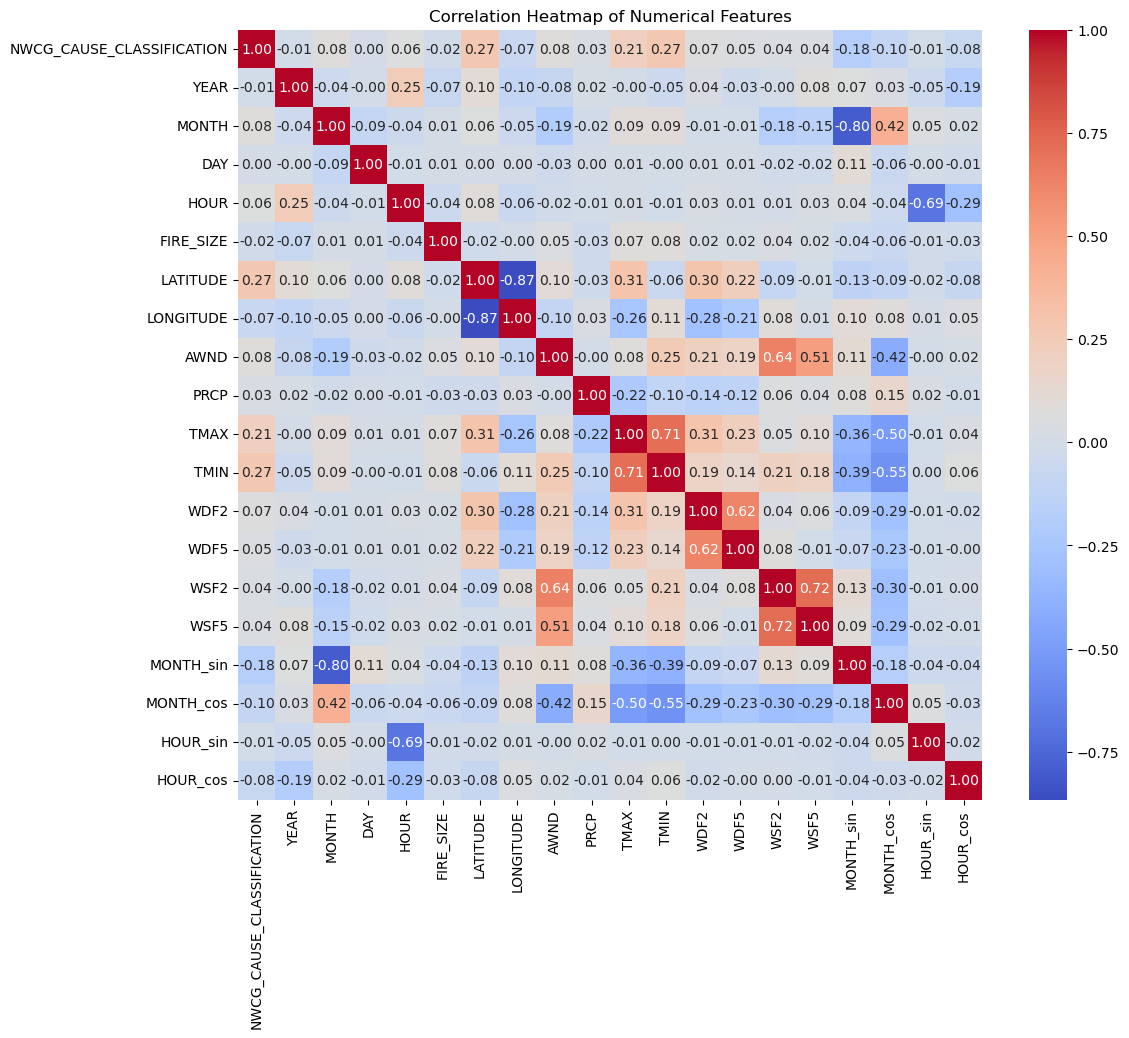

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = cal_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Correlation Matrix Analysis

This correlation matrix helps us understand the linear relationships between numerical features in the dataset and the target variable `NWCG_CAUSE_CLASSIFICATION` (where 0 = Human, 2 = Natural).

#### Key Correlations with Target (`NWCG_CAUSE_CLASSIFICATION`)

- **LATITUDE (0.27)** and **TMIN (0.27)** show the strongest positive correlation with the cause classification, suggesting geographic and temperature features may influence whether a fire was natural or human-caused.
- **TMAX (0.21)** and **AWND (0.08)** also show some positive correlation with the target.
- **MONTH_sin (-0.18)** and **MONTH_cos (-0.10)** are negatively correlated, indicating that the time of year (seasonality) has an impact on fire causes.

These features may provide predictive power when modeling wildfire causes.

#### Weather Feature Relationships

- **TMAX and TMIN (0.71)**: Strong correlation, as expected since maximum and minimum temperatures are typically related.
- **WSF2 and WSF5 (0.72)**: High correlation between wind speed measurements taken at two different times.
- **AWND and WSF2 (0.64)**: Average wind speed is well correlated with peak wind speeds.

These interrelated weather variables could affect fire spread and origin classification.

#### Spatial Features

- **LATITUDE and LONGITUDE (-0.87)**: Strong negative correlation, reflecting the geographic distribution of wildfires across California.

#### 🕒 Time-Based Features

- **HOUR_sin and HOUR (-0.69)**: This confirms that the sine encoding correctly captures the cyclical nature of hours in a day.
- **MONTH_sin and MONTH_cos** are also well correlated with each other and with `MONTH`, validating the effectiveness of cyclical encoding for time-based features.

#### ✅ Modeling Considerations

- Features like `LATITUDE`, `TMIN`, `TMAX`, and cyclical month encodings are likely to be useful predictors.
- Features such as `PRCP`, `FIRE_SIZE`, and `HOUR_cos` show weak linear correlation with the target, but may still capture important nonlinear patterns in classification models.

Overall, these insights will help in selecting and engineering features for model training.



### 5.2 Class Distribution Bar Plot

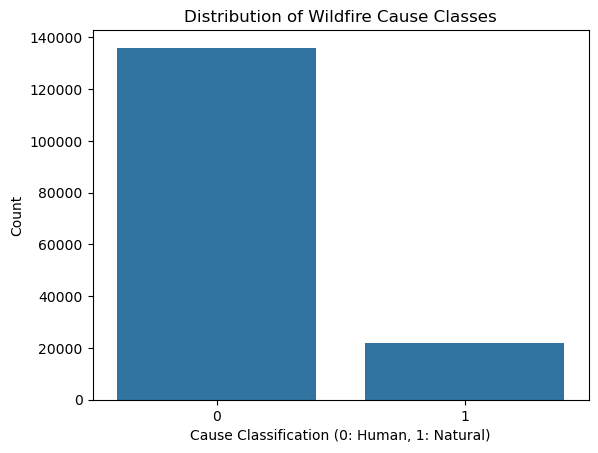

In [158]:
sns.countplot(x='NWCG_CAUSE_CLASSIFICATION', data=cal_df)
plt.title("Distribution of Wildfire Cause Classes")
plt.xlabel("Cause Classification (0: Human, 1: Natural)")
plt.ylabel("Count")
plt.show()

### ⚠️ Class Imbalance Observation

The distribution of the `NWCG_CAUSE_CLASSIFICATION` variable shows significant class imbalance:

- Class 0 (Human): 135,995 instances
- Class 1 (Natural): 21,809 instances

This imbalance indicates that human-caused fires dominate the dataset, which could bias the model toward predicting the majority class. Techniques such as resampling (oversampling the minority class or undersampling the majority), SMOTE, or class-weight adjustments in models may be necessary to handle this issue effectively.


### 5.3 KDE Distribution Plot

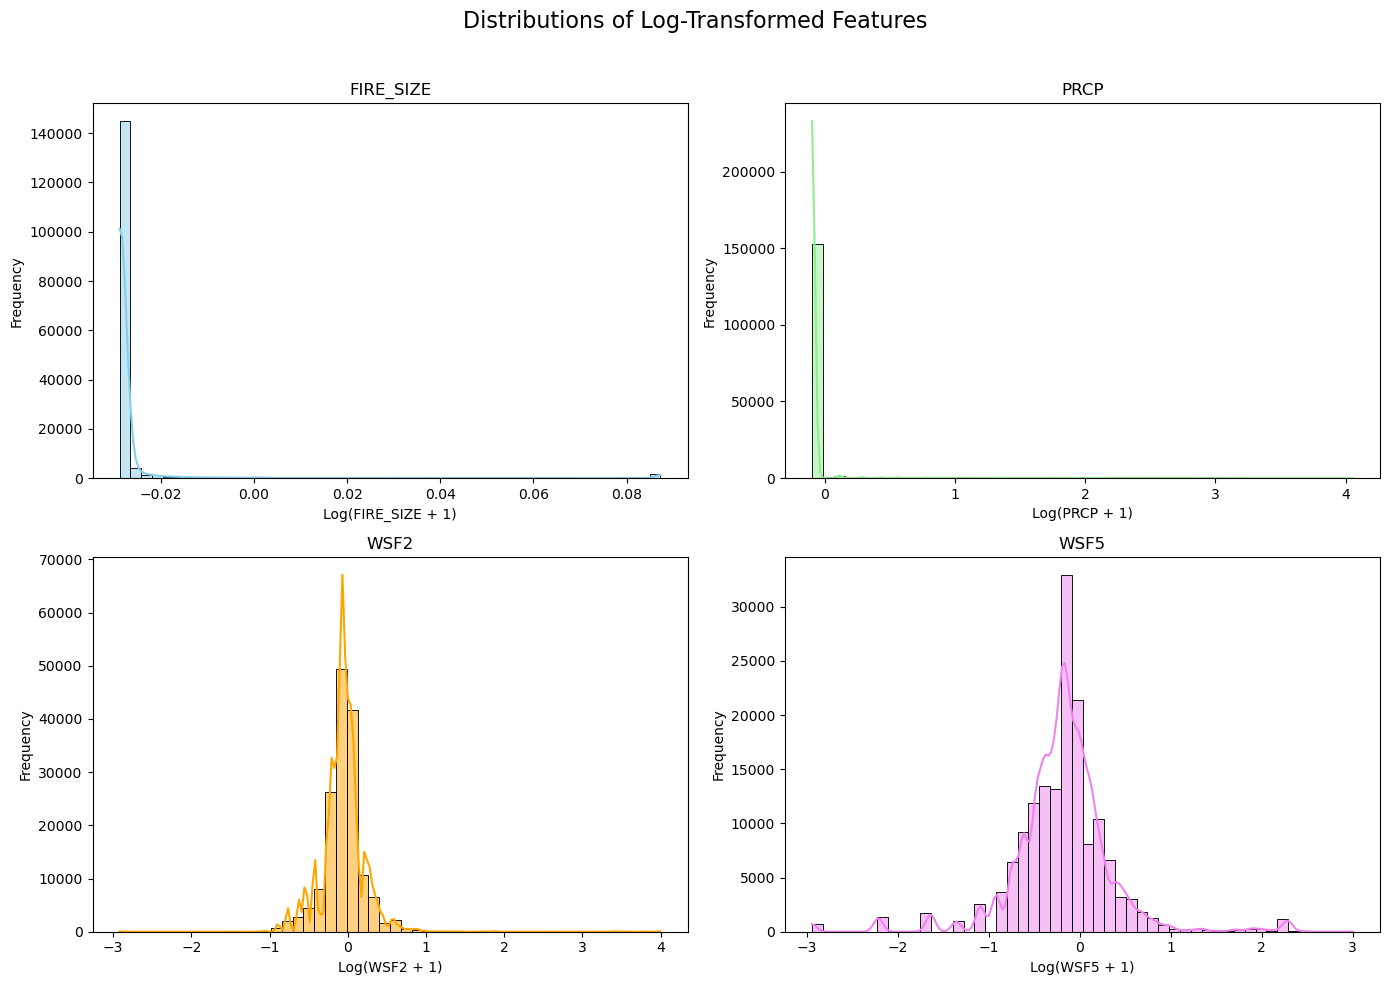

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distributions of Log-Transformed Features', fontsize=16)

# Define columns and colors
columns = ['FIRE_SIZE', 'PRCP', 'WSF2', 'WSF5']
colors = ['skyblue', 'lightgreen', 'orange', 'violet']

# Plot each column in its subplot
for ax, col, color in zip(axes.flat, columns, colors):
    sns.histplot(cal_df[col], kde=True, bins=50, color=color, ax=ax)
    ax.set_title(f'{col}')
    ax.set_xlabel(f'Log({col} + 1)')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [168]:
# Make a copy of the dataset
cal_df_copy = cal_df.copy()

In [175]:
from scipy.stats import boxcox

# Ensure all values are positive by adding a small constant if necessary
shift_value = abs(min(cal_df['FIRE_SIZE'].min(), cal_df['PRCP'].min())) + 1  # Adding 1 to ensure positivity

# Apply Box-Cox to FIRE_SIZE and PRCP directly in cal_df
cal_df['FIRE_SIZE'], _ = boxcox(cal_df['FIRE_SIZE'] + shift_value)
cal_df['PRCP'], _ = boxcox(cal_df['PRCP'] + shift_value)

# Check the transformed columns
print(cal_df[['FIRE_SIZE', 'PRCP']].head())


   FIRE_SIZE  PRCP
0   0.002987   0.0
1   0.002987   0.0
2   0.002987   0.0
3   0.002987   0.0
4   0.002987   0.0


In [176]:
# Check the skewness before and after Box-Cox transformation in cal_df
before_skew = cal_df[['FIRE_SIZE', 'PRCP']].skew()

# Print the skewness values
print("Skewness before Box-Cox transformation:")
print(before_skew)

Skewness before Box-Cox transformation:
FIRE_SIZE    0.000000
PRCP         5.389639
dtype: float64


### Why Apply Box-Cox After Log Transformation?

In data preprocessing, reducing **skewness** is crucial for many statistical and machine learning models to perform well. Here's a breakdown of why the **Box-Cox transformation** was applied even after performing a **log transformation**, using your data as an example.

#### Skewness After Log Transformation:
- `FIRE_SIZE`: **7.39** → Highly **right-skewed**
- `PRCP`: **8.95** → Extremely **right-skewed**
- `WSF2`: **1.40**
- `WSF5`: **-0.13**

Even after applying `log(x + 1)`, which is often the first go-to method to reduce skewness, **`FIRE_SIZE` and `PRCP` remained strongly skewed**. This indicates that the log transform alone wasn't sufficient to normalize the distribution.

#### What Does Box-Cox Do?

The **Box-Cox transformation** is a **power transform** that searches for an optimal lambda (λ) value to **stabilize variance** and **normalize the distribution**. It does this better than a fixed log transform because:

- It tries different exponent values (not just log or square root).
- It learns the best transformation for **your specific data**.
- It's only valid for **positive data**, which is why we made sure to shift the values if needed.

#### Results After Box-Cox:

**Skewness Before Box-Cox** (already log-transformed):
- `FIRE_SIZE`: **7.08**
- `PRCP`: **8.74**

**Skewness After Box-Cox:**
- `FIRE_SIZE`: **0.00** → Near-perfect symmetry 
- `PRCP`: **5.38** → Improved but still skewed

#### Interpretation

- `FIRE_SIZE`: The Box-Cox transformation **drastically reduced the skewness to 0**, effectively normalizing the data. This makes the distribution symmetric and more suitable for linear models.
- `PRCP`: The skewness **decreased**, but still remains right-skewed, possibly due to **zero inflation or extreme outliers**. Additional treatment (e.g. QuantileTransformer) might be needed.

- Log transform is a good first step.
- If skewness persists, **Box-Cox dynamically adjusts the transformation** to better normalize.
- It's especially effective when log alone doesn't reduce heavy skewness — as seen with `FIRE_SIZE`.



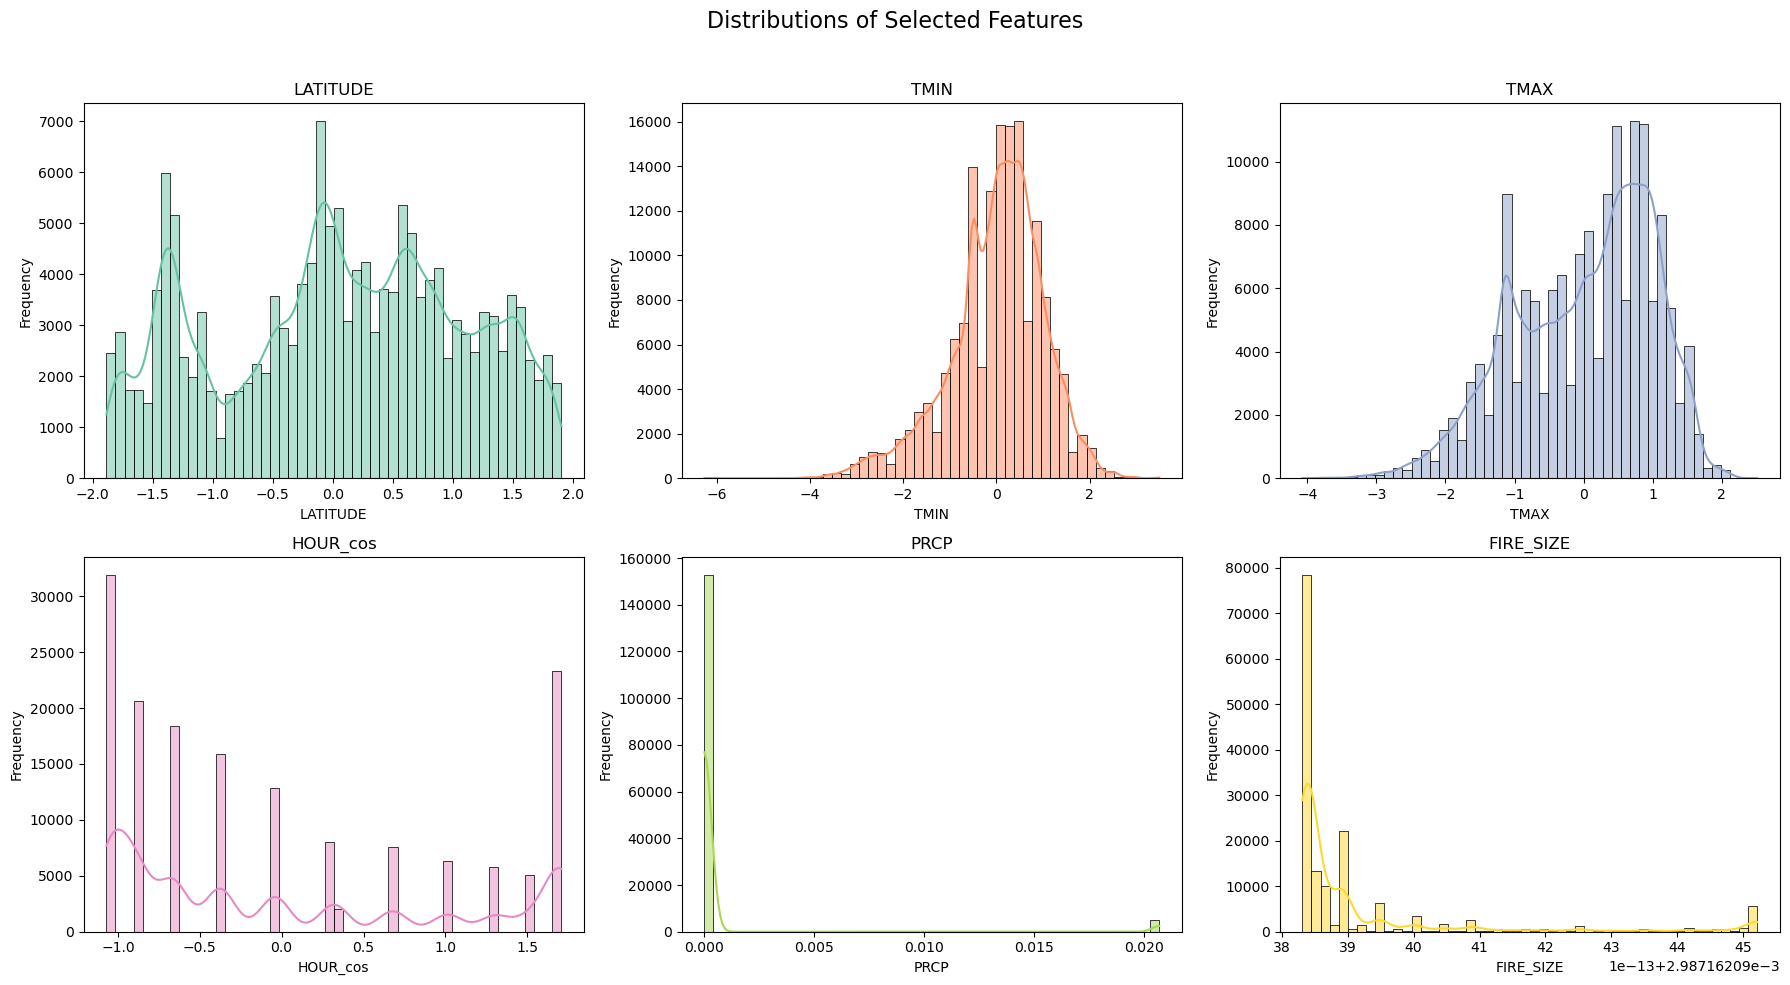

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns you're interested in
columns_to_plot = ['LATITUDE', 'TMIN', 'TMAX', 'HOUR_cos', 'PRCP', 'FIRE_SIZE']
colors = sns.color_palette("Set2", len(columns_to_plot))  # Get a distinct color palette for the columns

# Set up subplot grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distributions of Selected Features', fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column in its subplot
for ax, col, color in zip(axes, columns_to_plot, colors):
    sns.histplot(cal_df[col], kde=True, bins=50, color=color, ax=ax)
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [180]:
# Define the columns you're interested in
columns_to_check = ['LATITUDE', 'TMIN', 'TMAX', 'HOUR_cos', 'PRCP', 'FIRE_SIZE']

# Calculate skewness for these columns
skewness_values = cal_df[columns_to_check].skew()

# Print the skewness values
print("Skewness of selected features:")
print(skewness_values)

Skewness of selected features:
LATITUDE    -0.145994
TMIN        -0.652381
TMAX        -0.488543
HOUR_cos     0.612020
PRCP         5.389639
FIRE_SIZE    0.000000
dtype: float64


In [182]:
cal_df.describe()

,NWCG_CAUSE_CLASSIFICATION,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,MONTH_sin,MONTH_cos,HOUR_sin,HOUR_cos
count,157804.000000,157804.000000,157804.000000,157804.000000,157804.000000,1.578040e+05,157804.000000,157804.000000,157804.000000,157804.000000,157804.000000,157804.000000,157804.000000,157804.000000,157804.000000,157407.000000,157804.000000,157804.000000,157804.000000,157804.000000
mean,0.138203,2007.292420,7.102830,15.480127,12.223885,2.987162e-03,0.057056,-0.018727,0.018180,0.000647,0.015577,0.011339,0.006016,0.013575,-0.057834,-0.191355,-0.019648,-0.005234,0.022272,-0.002821
std,0.345114,7.124795,2.233498,8.956580,6.267574,1.662200e-13,1.014751,1.001443,0.998201,0.003601,0.997789,1.004303,0.990661,0.989351,0.278665,0.566664,0.993029,0.993245,0.994666,1.009465
min,0.000000,1992.000000,1.000000,1.000000,0.000000,2.987162e-03,-1.884811,-2.070652,-2.697633,0.000000,-4.073783,-6.260455,-4.577048,-4.222486,-2.917775,-2.946922,-1.138693,-0.973475,-1.223366,-1.070254
25%,0.000000,2002.000000,6.000000,8.000000,9.000000,2.987162e-03,-0.713024,-0.735987,-0.624952,0.000000,-0.739000,-0.518963,-0.278043,-0.173118,-0.191333,-0.386880,-0.918654,-0.752243,-0.998968,-0.884130
50%,0.000000,2007.000000,7.000000,15.000000,13.000000,2.987162e-03,0.078600,-0.142871,0.008144,0.000000,0.213796,0.131017,0.358847,0.276812,-0.056997,-0.198454,-0.317494,-0.147825,0.018059,-0.375632
75%,0.000000,2013.000000,9.000000,23.000000,17.000000,2.987162e-03,0.841234,0.682714,0.548493,0.000000,0.848993,0.672667,0.677292,0.576765,0.061411,0.023906,0.503706,0.677826,0.451562,1.013612
max,1.000000,2020.000000,12.000000,31.000000,23.000000,2.987162e-03,1.904239,2.973951,6.956062,0.020702,2.516384,3.489248,1.154959,1.176672,3.998017,3.001367,2.146105,2.329126,2.126490,1.708234


In [185]:
cal_df.isnull().sum().sort_values(ascending=False)


WSF5                         397
NWCG_CAUSE_CLASSIFICATION      0
YEAR                           0
HOUR_sin                       0
MONTH_cos                      0
MONTH_sin                      0
WSF2                           0
WDF5                           0
WDF2                           0
TMIN                           0
TMAX                           0
PRCP                           0
AWND                           0
LONGITUDE                      0
LATITUDE                       0
FIRE_SIZE                      0
HOUR                           0
DAY                            0
MONTH                          0
HOUR_cos                       0
dtype: int64

In [191]:
cal_df = cal_df.dropna(subset=['WSF5'])

### Handling Missing Values After Log Transformation on `WSF5`

After applying the `log(x + 1)` transformation to continuous variables, we observed that the column `WSF5` had **397 missing values**. Here's why this occurred and how we addressed it.

#### Why Did Missing Values Appear?

- The log transformation was applied using:
  ```python
  np.log(x + 1)


In [192]:
cal_df.isnull().sum().sort_values(ascending=False)

NWCG_CAUSE_CLASSIFICATION    0
YEAR                         0
HOUR_sin                     0
MONTH_cos                    0
MONTH_sin                    0
WSF5                         0
WSF2                         0
WDF5                         0
WDF2                         0
TMIN                         0
TMAX                         0
PRCP                         0
AWND                         0
LONGITUDE                    0
LATITUDE                     0
FIRE_SIZE                    0
HOUR                         0
DAY                          0
MONTH                        0
HOUR_cos                     0
dtype: int64

### 5.3 Histograms + KDE for Numeric Features

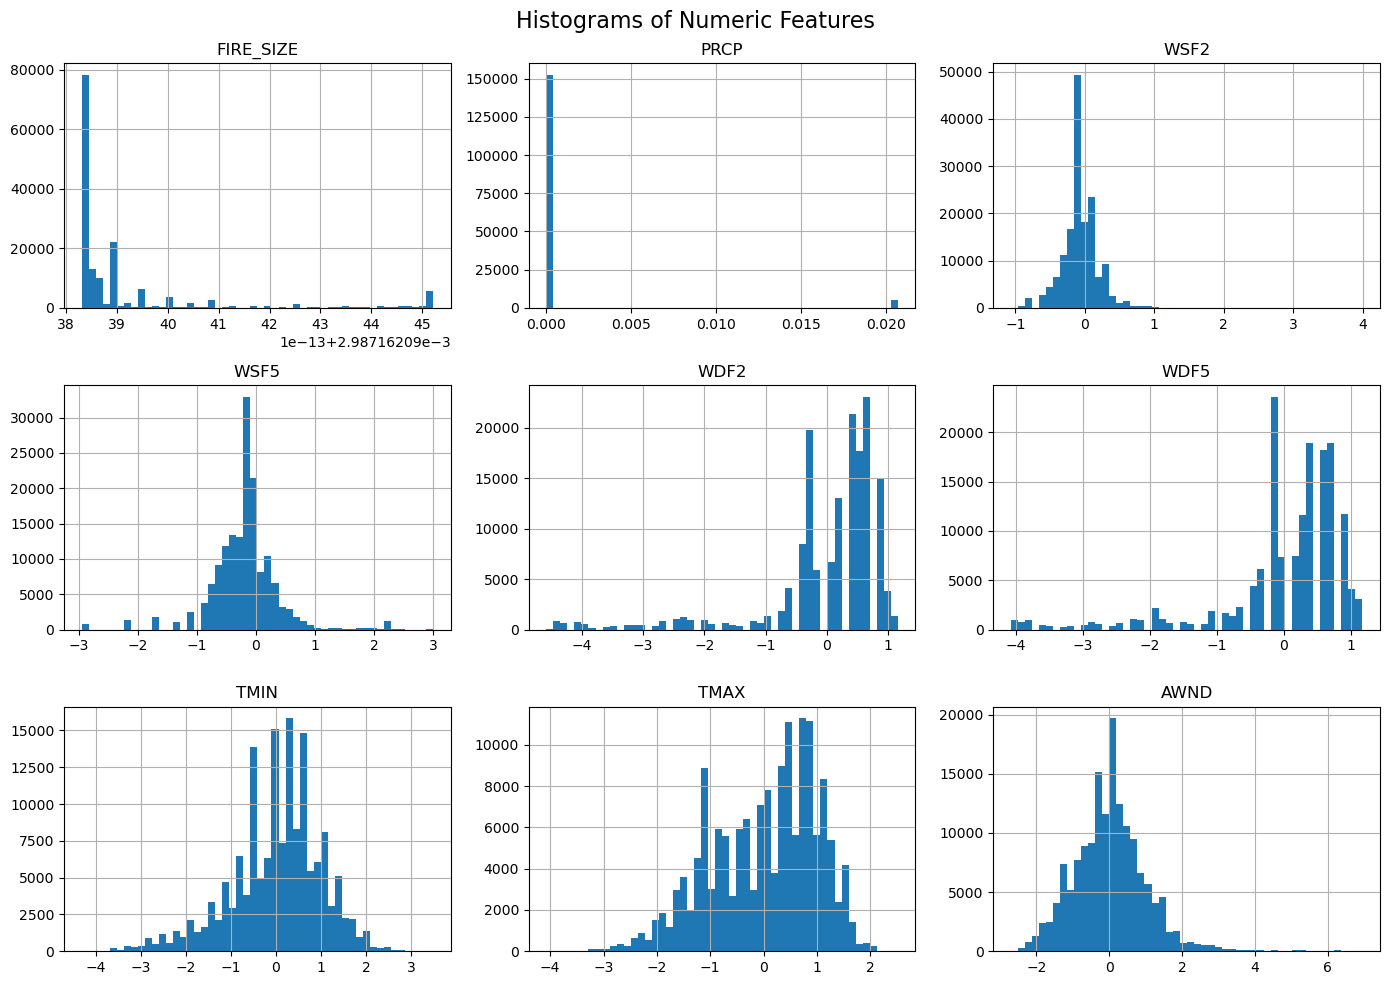

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['FIRE_SIZE', 'PRCP', 'WSF2', 'WSF5', 'WDF2', 'WDF5', 'TMIN', 'TMAX', 'AWND']
cal_df[numeric_cols].hist(figsize=(14,10), bins=50)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

### 5.4 Boxplots for Outlier Detection

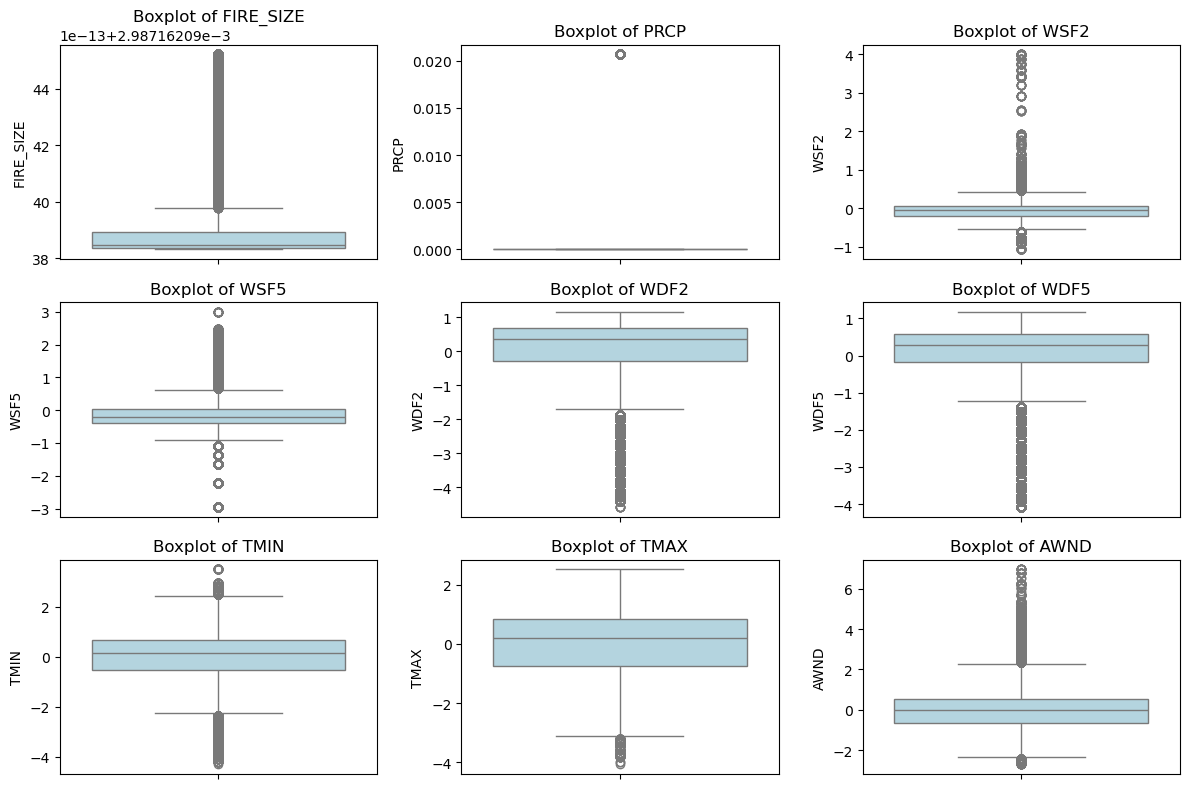

In [197]:
# List of numeric columns for boxplot
numeric_cols = ['FIRE_SIZE', 'PRCP', 'WSF2', 'WSF5', 'WDF2', 'WDF5', 'TMIN', 'TMAX', 'AWND']

# Set up plot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flatten()

# Loop over columns and axes
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=cal_df[col], ax=axes[i], color='lightblue')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

# Remove any unused subplots
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 📦 Understanding Boxplots and Outliers

#### 1. What is a Boxplot?
Each plot visualizes the distribution of a variable using five summary statistics:
- **Box**: Represents the middle 50% of the data (from Q1 to Q3).
- **Line inside box**: Median (Q2).
- **Whiskers**: Extend to 1.5×IQR (Interquartile Range) beyond the box.
- **Dots beyond whiskers**: Outliers — extreme values far from the bulk of the data.

#### 2. Key Insights from the Boxplots
- **FIRE_SIZE**: Data is tightly clustered with a few high outliers. The small magnitude suggests a transformation or normalization may be in effect.
- **PRCP (Precipitation)**: Heavily skewed with most values at zero — a few measurable precipitation events stand out as strong outliers.
- **WSF2, WSF5 (Wind Speeds)**: Show many high-value outliers, possibly due to strong wind days — important for fire spread.
- **WDF2, WDF5 (Wind Directions)**: More symmetric but include low-end outliers — potentially representing rare directional wind patterns.
- **TMIN, TMAX (Temperature extremes)**: Fairly symmetric but show outliers, especially on the lower (cold) end.
- **AWND (Average Wind)**: Contains numerous upper outliers — indicating days with consistently strong winds.

#### 3. Why This Matters for Modeling
Since the goal is to predict wildfire cause (natural vs human), outliers may contain valuable information:
- Could reflect rare but critical conditions (e.g., strong wind → lightning-induced fires).
- May highlight suspicious patterns (e.g., fire with no wind → possibly human-caused).

#### 4. Next Steps Before Modeling
Outliers can impact models differently:
- **Logistic regression**: Sensitive to outliers.
- **Tree-based models** (e.g., Random Forests): More robust to them.

🔧 Possible preprocessing strategies:
- Cap or floor extreme values (`winsorization`)
- Apply transformations (e.g., `log`, `Box-Cox`)
- Use models tolerant to outliers (e.g., `XGBoost`, `Random Forest`)


In [202]:
from scipy.stats import boxcox

# Step 1: Ensure values are positive (Box-Cox requires strictly positive values)
# Add a shift if needed
wsf2_min = cal_df['WSF2'].min()
wsf5_min = cal_df['WSF5'].min()

shift_wsf2 = 1 - wsf2_min if wsf2_min <= 0 else 0
shift_wsf5 = 1 - wsf5_min if wsf5_min <= 0 else 0

# Step 2: Apply Box-Cox transformation to the original DataFrame
cal_df['WSF2'] = boxcox(cal_df['WSF2'] + shift_wsf2)[0]
cal_df['WSF5'] = boxcox(cal_df['WSF5'] + shift_wsf5)[0]

# Check the updated DataFrame and skewness
print(cal_df[['WSF2', 'WSF5']].head())

       WSF2      WSF5
0  0.441332  2.347727
1  0.820275  3.511782
2  0.753043  3.046354
3  0.753043  3.398142
4  0.753043  3.398142


In [204]:
# Since Box-Cox was applied directly on the original cal_df
skewness_after_boxcox = cal_df[['WSF2', 'WSF5']].skew()

print("\nSkewness after Box-Cox transformation:")
print(skewness_after_boxcox)


Skewness after Box-Cox transformation:
WSF2    0.060769
WSF5    0.417876
dtype: float64


### Box-Cox Transformation on Wind Speed Features (WSF2 and WSF5)

To address skewness and outliers in wind speed variables (`WSF2`, `WSF5`), we applied the **Box-Cox transformation**, which is a common method used to stabilize variance and make the data more normally distributed. This can be particularly useful for improving the performance of machine learning models, especially those sensitive to feature distributions.

#### Why Box-Cox?

- Box-Cox is designed to reduce skewness in data and approximate a Gaussian distribution.
- Many ML algorithms assume features are normally distributed, or at least symmetric.
- Skewed distributions can negatively impact model accuracy and learning.

#### Results:
Skewness for WSF2: 0.06
Skewness for WSF5: 0.42
These are significant improvements from the original distributions, bringing them much closer to symmetry. This normalization can lead to better model stability and interpretability.

In [ ]:

# Step 1: Create a binary flag for days with zero precipitation
cal_df['PRCP_zero_flag'] = np.where(cal_df['PRCP'] == 0, 1, 0)

In [208]:
import numpy as np
from scipy.stats import boxcox

# Check the remaining columns
print(cal_df[['PRCP', 'PRCP_zero_flag']].head())

# You can also check skewness for the PRCP and PRCP_zero_flag columns
skewness_after_transforms = cal_df[['PRCP', 'PRCP_zero_flag']].skew()
print("\nSkewness after transformations:")
print(skewness_after_transforms)


   PRCP  PRCP_zero_flag
0   0.0               1
1   0.0               1
2   0.0               1
3   0.0               1
4   0.0               1

Skewness after transformations:
PRCP              5.389398
PRCP_zero_flag   -5.389398
dtype: float64


In [210]:
import numpy as np
from scipy.stats import boxcox

# Step 1: Apply Box-Cox transformation again to PRCP
shift_value = abs(cal_df['PRCP'].min()) + 1  # Adding a small shift to make all values positive
cal_df['PRCP_BoxCox_again'], _ = boxcox(cal_df['PRCP'] + shift_value)

# Step 2: Check skewness of PRCP and the new PRCP_BoxCox_again
skewness_after_boxcox = cal_df[['PRCP', 'PRCP_BoxCox_again']].skew()

# Print the skewness
print("\nSkewness after Box-Cox transformation:")
print(skewness_after_boxcox)


Skewness after Box-Cox transformation:
PRCP                 5.389398
PRCP_BoxCox_again    5.389398
dtype: float64


### 🌧️ Note on Precipitation (PRCP)
We initially explored a zero-flag transformation for PRCP to handle sparsity, but this approach didn’t yield improved performance or interpretability. Therefore, we chose to retain the original PRCP values without transformation.

In [212]:
# Drop the PRCP_BoxCox and PRCP_zero_flag columns from the dataset
cal_df.drop(['PRCP_BoxCox_again', 'PRCP_zero_flag'], axis=1, inplace=True)

# Check the updated dataset
print(cal_df.head())

   NWCG_CAUSE_CLASSIFICATION  YEAR  MONTH  DAY  HOUR  FIRE_SIZE  LATITUDE  \
0                          0  2005      2    2    13   0.002987  1.115575   
1                          1  2004      5   12     8   0.002987  0.673935   
2                          0  2004      5   31    19   0.002987  0.694384   
3                          1  2004      6   28    16   0.002987  0.524351   
4                          1  2004      6   28    16   0.002987  0.524351   

   LONGITUDE      AWND  PRCP      TMAX      TMIN      WDF2      WDF5  \
0  -0.401276 -1.435475   0.0 -2.088793 -2.468904 -2.825601 -2.572744   
1  -0.105742  0.548493   0.0 -0.500801 -0.952283  0.518069  0.876718   
2  -0.268456 -0.173317   0.0  0.610794 -0.193973  0.518069  0.426789   
3   0.135600  0.096858   0.0  0.769593  0.456007 -0.278043 -0.473071   
4   0.125908  0.096858   0.0  0.769593  0.456007 -0.278043 -0.473071   

       WSF2      WSF5  MONTH_sin  MONTH_cos  HOUR_sin  HOUR_cos  
0  0.441332  2.347727   1.926065   1.5

In [213]:
cal_df.describe()

,NWCG_CAUSE_CLASSIFICATION,YEAR,MONTH,DAY,HOUR,FIRE_SIZE,LATITUDE,LONGITUDE,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,MONTH_sin,MONTH_cos,HOUR_sin,HOUR_cos
count,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,1.574070e+05,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000,157407.000000
mean,0.138348,2007.294904,7.099919,15.473219,12.222849,2.987162e-03,0.056229,-0.017798,0.022487,0.000647,0.018791,0.016280,0.009971,0.016353,0.745718,3.320715,-0.020058,-0.008836,0.022378,-0.002330
std,0.345266,7.125293,2.227161,8.956838,6.269248,1.662849e-13,1.015211,1.001873,0.994799,0.003601,0.996149,0.998798,0.984975,0.985955,0.155063,0.756318,0.993334,0.990230,0.994856,1.009524
min,0.000000,1992.000000,1.000000,1.000000,0.000000,2.987162e-03,-1.884811,-2.070652,-2.697633,0.000000,-4.073783,-4.310514,-4.577048,-4.072510,0.000000,0.000000,-1.138693,-0.973475,-1.223366,-1.070254
25%,0.000000,2002.000000,6.000000,8.000000,9.000000,2.987162e-03,-0.717083,-0.735577,-0.624952,0.000000,-0.739000,-0.518963,-0.278043,-0.173118,0.672912,3.046354,-0.918654,-0.752243,-0.998968,-0.884130
50%,0.000000,2007.000000,7.000000,15.000000,13.000000,2.987162e-03,0.077266,-0.142325,0.008144,0.000000,0.213796,0.131017,0.358847,0.276812,0.753043,3.297954,-0.317494,-0.147825,0.018059,-0.375632
75%,0.000000,2013.000000,9.000000,23.000000,17.000000,2.987162e-03,0.840967,0.683378,0.548493,0.000000,0.848993,0.672667,0.677292,0.576765,0.820275,3.598508,0.503706,0.677826,0.451562,1.013612
max,1.000000,2020.000000,12.000000,31.000000,23.000000,2.987162e-03,1.904239,2.973951,6.956062,0.020702,2.516384,3.489248,1.154959,1.176672,2.211601,7.937389,2.146105,2.329126,2.126490,1.708234


#### 5.5 Feature vs. Target (Categorical Features):

### 6. Saving Dataframe to CSV for Model Training

In [215]:
# Save the CAL_FIRE dataframe to a CSV file
cal_df.to_csv('final_csv1.csv', index=False)